In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def const(x, *par):
    return 0

In [7]:
def cwgp_regression(x, y, cwgp_model):
    kernel = GPy.kern.RBF(1)

    ratio = 0.9
    length = len(rate)
    train = int(ratio*length)
    train_up, train_low = train, train-train

    res = scipy.optimize.curve_fit(poly,  np.ravel(x[train_low:train_up]), np.ravel(y[train_low:train_up]), p0=(-1,-1), maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: poly(x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x[train_low:train_up], y[train_low:train_up], mean_function=mf, kernel=kernel)
    model.optimize()

    domain_discrete = np.arange(1940,2031).reshape(-1,1)
    y_res = model.predict(x)
    y_all = model.predict(domain_discrete)
    y_pred= y_res[0]
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    for cwgp in cwgp_model[::-1]:
        y_pred = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_pred)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)
        y = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y)


    rmse = mean_squared_error(y[train_up:], y_pred[train_up:], squared=False)
    mae = mean_absolute_error(y[train_up:], y_pred[train_up:])
    txt = f"""rmse : {rmse} \n mae : {mae}"""

    name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
    name = "_".join(name)
    if rmse < 0.003371134608025886:
        domain = np.linspace(1940,2030,91)
        plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
        plt.scatter(x[train_low:train_up], y[train_low:train_up], marker="x", color='black', label="data")
        plt.scatter(x[train_up:], y[train_up:], marker="x", color='red')
        plt.plot(np.linspace(1940,2030,91),y_mean, label="mean")
        plt.ylim([0.1,0.35])
        plt.legend()
        plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.grid(True)
        plt.show()
        


    print(rmse,mae)
    return rmse, mae

In [8]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))


  0%|          | 1/1296 [00:00<15:01,  1.44it/s]

params:[-8.43707943e-02  1.66682040e+02]
0.003560361948168518 0.0027990427690889686
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))


  0%|          | 2/1296 [00:01<15:30,  1.39it/s]

params:[-8.43707393e-02  1.66681929e+02]
0.003560367437698114 0.0027990448574238785
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))


  0%|          | 3/1296 [00:02<17:53,  1.20it/s]

params:[-1.02580417e-01  2.03162444e+02]
0.006030381367483659 0.005493483856668813
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-9.49170246e+02  1.85790311e+06]


  0%|          | 4/1296 [00:31<4:14:27, 11.82s/it]

0.004635510862236208 0.004189632371594353
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))


  0%|          | 5/1296 [00:31<2:48:32,  7.83s/it]

params:[-8.55310374e-02  1.67938091e+02]
0.003735094057773427 0.002760849183083871
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-8.39185320e-02  1.63633209e+02]


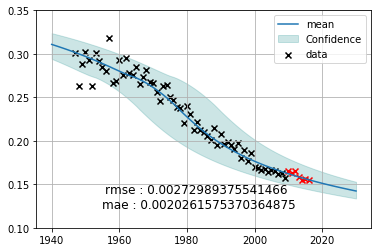

  0%|          | 6/1296 [00:32<1:59:16,  5.55s/it]

0.00272989375541466 0.0020261575370364875
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))


  1%|          | 7/1296 [00:34<1:28:25,  4.12s/it]

params:[-8.43707929e-02  1.66682033e+02]
0.0035603709052356206 0.0027990473719948544
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))


  1%|          | 8/1296 [00:35<1:08:42,  3.20s/it]

params:[-8.43708143e-02  1.66682078e+02]
0.0035603644248514504 0.00279904431181055
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))


  1%|          | 9/1296 [00:36<55:06,  2.57s/it]  

params:[-1.02579059e-01  2.03159794e+02]
0.006030001491246208 0.005493021858979656
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1. -1.]


  1%|          | 10/1296 [00:45<1:35:15,  4.44s/it]

0.28733899737086005 0.2873050796856426
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))


  1%|          | 11/1296 [00:46<1:12:10,  3.37s/it]

params:[-8.55310438e-02  1.67938102e+02]
0.0037350932666851563 0.0027608515200058365
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-8.39185678e-02  1.63633279e+02]


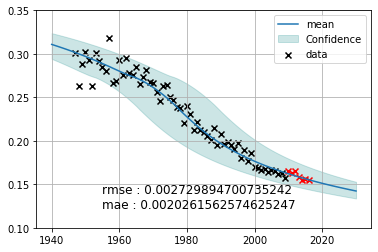

  1%|          | 12/1296 [00:47<57:21,  2.68s/it]  

0.002729894700735242 0.0020261562574625247
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))


  1%|          | 13/1296 [00:48<46:38,  2.18s/it]

params:[-1.03508924e-01  2.05014322e+02]
0.006002075138923352 0.005460400890439984
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))


  1%|          | 14/1296 [00:49<39:02,  1.83s/it]

params:[-1.03509233e-01  2.05015020e+02]
0.0060019951648383535 0.005460296709559069
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))


  1%|          | 15/1296 [00:50<34:33,  1.62s/it]

params:[-9.69720321e-02  1.91997962e+02]
0.004705473782251263 0.0037647538532583507
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))
params:[-7.35529196e+07  1.44631268e+11]


  1%|          | 16/1296 [00:57<1:07:32,  3.17s/it]

0.007686502656853126 0.006417457058007019
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))


  1%|▏         | 17/1296 [00:58<53:35,  2.51s/it]  

params:[-1.01569964e-01  2.00264056e+02]
0.004740433283194309 0.0037836827540778223
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))


  1%|▏         | 18/1296 [00:59<44:59,  2.11s/it]

params:[-1.02750896e-01  2.01570901e+02]
0.004703934503478387 0.0037682364083814995
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 1))


  1%|▏         | 19/1296 [01:21<2:53:22,  8.15s/it]

params:[-1.03015944e-01  2.04031565e+02]
0.005151962899308586 0.0043727695348645
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 2))


  2%|▏         | 20/1296 [01:31<3:03:16,  8.62s/it]

params:[-2.74921294e+00  5.43410449e+03]
0.0038176701851546165 0.0033447141846917605
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 1))


  2%|▏         | 21/1296 [01:56<4:49:14, 13.61s/it]

params:[-6.73018459e-02  1.33444593e+02]
0.005467287093760635 0.004691267090576843
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 2))


  2%|▏         | 22/1296 [02:15<5:23:56, 15.26s/it]

params:[-1.09767185e-01  2.17304651e+02]
0.007208864703566576 0.006862042668569558
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))


  2%|▏         | 23/1296 [02:33<5:40:14, 16.04s/it]

params:[-9.76115987e-02  1.92553317e+02]
0.0036558076322535213 0.003050753936588526
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))


  2%|▏         | 24/1296 [02:37<4:25:27, 12.52s/it]

params:[-1.02309411e-01  2.00756007e+02]
0.0037461807446512356 0.0027270973262557285
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))
params:[-8.00714097e-02  1.57470713e+02]


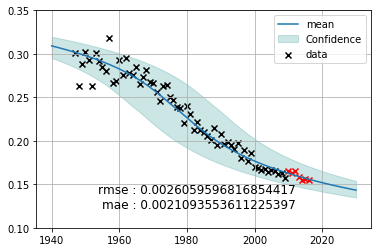

  2%|▏         | 25/1296 [02:38<3:10:51,  9.01s/it]

0.0026059596816854417 0.0021093553611225397
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))
params:[-8.00713789e-02  1.57470655e+02]


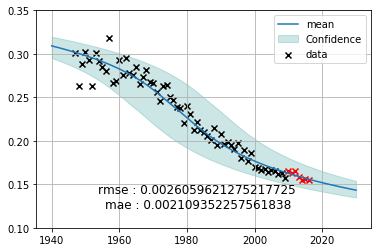

  2%|▏         | 26/1296 [02:39<2:18:45,  6.56s/it]

0.0026059621275217725 0.002109352257561838
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))


  2%|▏         | 27/1296 [02:40<1:42:59,  4.87s/it]

params:[-1.07456015e-01  2.12854784e+02]
0.005775594669590453 0.005188024333362244
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))


  2%|▏         | 28/1296 [02:50<2:16:51,  6.48s/it]

params:[-1.02024927e-01  2.02183967e+02]
0.003625205088812173 0.002746532822408415
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
params:[-8.54986619e-02  1.66714645e+02]


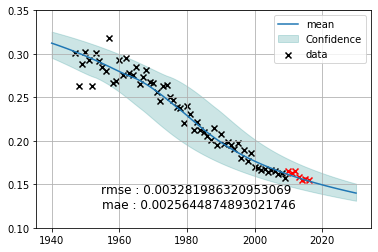

  2%|▏         | 29/1296 [02:51<1:40:14,  4.75s/it]

0.003281986320953069 0.0025644874893021746
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


  2%|▏         | 30/1296 [02:51<1:13:27,  3.48s/it]

params:[-7.97334328e-02  1.54248103e+02]
0.004251014032817363 0.003551508455963728
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))
params:[-7.25100411e-02  1.41794484e+02]


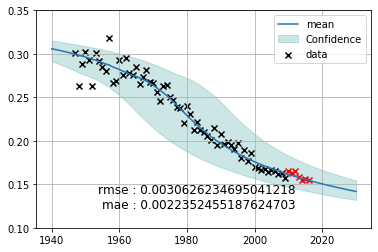

  2%|▏         | 31/1296 [02:52<57:05,  2.71s/it]  

0.0030626234695041218 0.0022352455187624703
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))
params:[-7.25100894e-02  1.41794586e+02]


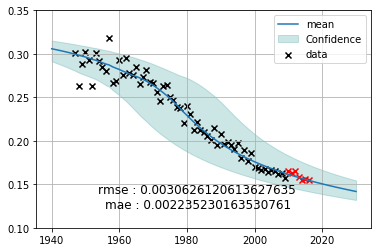

  2%|▏         | 32/1296 [02:53<46:02,  2.19s/it]

0.0030626120613627635 0.002235230163530761
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))


  3%|▎         | 33/1296 [02:54<38:53,  1.85s/it]

params:[-1.00626198e-01  1.99415663e+02]
0.003947293100298378 0.0029196567519362998
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))


  3%|▎         | 34/1296 [02:59<58:31,  2.78s/it]

params:[-1.00662101e-01  1.99453467e+02]
0.0038887182933267186 0.0029670733566799896
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


  3%|▎         | 35/1296 [03:00<44:45,  2.13s/it]

params:[-7.86416704e-02  1.52101399e+02]
0.0037398290282161487 0.00301161097510465
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


  3%|▎         | 36/1296 [03:00<35:29,  1.69s/it]

params:[-6.92292469e-02  1.32482778e+02]
0.004587896879995128 0.0039399741505712115
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 1))


  3%|▎         | 37/1296 [03:01<28:50,  1.37s/it]

params:[-8.43708339e-02  1.66682116e+02]
0.003560366756632965 0.002799045786517474
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 2))


  3%|▎         | 38/1296 [03:02<26:24,  1.26s/it]

params:[-8.43707976e-02  1.66682043e+02]
0.0035603695179037406 0.002799046680094774
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 1))


  3%|▎         | 39/1296 [03:03<24:19,  1.16s/it]

params:[-1.02581975e-01  2.03165567e+02]
0.006030512900399706 0.005493638267596218
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 2))


  3%|▎         | 40/1296 [03:12<1:13:42,  3.52s/it]

params:[-1.03583897e-01  2.05203171e+02]
0.004506315421264062 0.0035700265747748428
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))
params:[-8.55310445e-02  1.67938104e+02]
0.003735089973627303

  3%|▎         | 41/1296 [03:13<56:30,  2.70s/it]  

 0.0027608516658192933
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))
params:[-8.39184126e-02  1.63632972e+02]


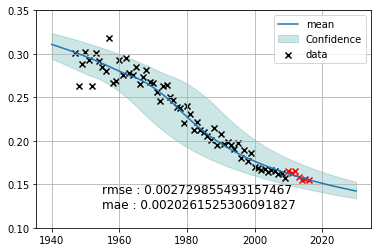

  3%|▎         | 42/1296 [03:14<45:40,  2.19s/it]

0.002729855493157467 0.0020261525306091827
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 1))


  3%|▎         | 43/1296 [03:15<41:56,  2.01s/it]

params:[-8.43707490e-02  1.66681949e+02]
0.003560366086927095 0.0027990442912065434
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 2))


  3%|▎         | 44/1296 [03:18<48:34,  2.33s/it]

params:[-8.43708065e-02  1.66682064e+02]
0.0035603620527192847 0.0027990430450567927
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 1))


  3%|▎         | 45/1296 [03:20<42:11,  2.02s/it]

params:[-1.02580288e-01  2.03162221e+02]
0.006030227819129214 0.005493296514697372
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 2))
params:[-1.10768934e+15  2.20842125e+18]


  4%|▎         | 46/1296 [03:28<1:20:44,  3.88s/it]

0.0895524543522523 0.08945198745130344
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))


  4%|▎         | 47/1296 [03:29<1:01:26,  2.95s/it]

params:[-8.55309879e-02  1.67937993e+02]
0.0037350818672739587 0.0027608541527613622
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))
params:[-8.3918642e-02  1.6363342e+02]


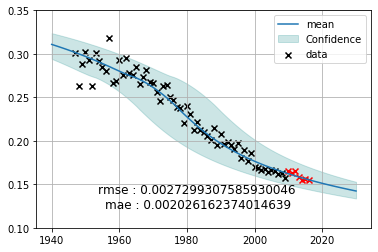

  4%|▎         | 48/1296 [03:30<50:39,  2.44s/it]  

0.0027299307585930046 0.002026162374014639
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 1))


  4%|▍         | 49/1296 [03:31<42:58,  2.07s/it]

params:[-1.03508084e-01  2.05012712e+02]
0.006001849989388648 0.005460124818916667
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 2))


  4%|▍         | 50/1296 [03:32<37:12,  1.79s/it]

params:[-1.03506657e-01  2.05009940e+02]
0.006001510145274661 0.005459710256083994
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 1))


  4%|▍         | 51/1296 [03:34<33:42,  1.62s/it]

params:[-9.69721850e-02  1.91998307e+02]
0.004705444583060651 0.003764702354561294
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2))


  4%|▍         | 52/1296 [03:59<3:01:03,  8.73s/it]

params:[-1.01089533e-01  2.00251222e+02]
0.005619993540079638 0.004990322255274416
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 1))


  4%|▍         | 53/1296 [04:00<2:12:09,  6.38s/it]

params:[-1.01570259e-01  2.00264640e+02]
0.004740744844526989 0.003784140590921125
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 2))


  4%|▍         | 54/1296 [04:01<1:38:25,  4.75s/it]

params:[-1.02751477e-01  2.01572105e+02]
0.004703842336971568 0.003768140537030693
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 1))


  4%|▍         | 55/1296 [04:12<2:16:05,  6.58s/it]

params:[-8.43617393e-02  1.66665324e+02]
0.0035590409548760466 0.0027999621865123386
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 2))


  4%|▍         | 56/1296 [04:22<2:40:17,  7.76s/it]

params:[-1.02993954e-01  2.03985259e+02]
0.005154647371096781 0.0043768300524061055
(('sa', 1), ('sa', 2), ('sal', 2), ('sal', 1))


  4%|▍         | 57/1296 [04:29<2:31:52,  7.35s/it]

params:[-9.89996754e-02  1.96052623e+02]
0.004488233922878866 0.003515358100694251
(('sa', 1), ('sa', 2), ('sal', 2), ('sal', 2))


  4%|▍         | 58/1296 [05:14<6:25:59, 18.71s/it]

params:[-9.22602231e-02  1.82835722e+02]
0.003567928547755461 0.002992892929215182
(('sa', 1), ('sa', 2), ('sal', 2), ('box_cox', 1))
params:[ 2.08013850e-03 -2.56130251e+00]


  5%|▍         | 59/1296 [05:18<4:54:40, 14.29s/it]

0.09968293079307115 0.0995374094497379
(('sa', 1), ('sa', 2), ('sal', 2), ('box_cox', 2))


  5%|▍         | 60/1296 [05:23<4:01:29, 11.72s/it]

params:[-1.31176241e-03  9.63220818e+00]
0.032186634580004134 0.03146885213562006
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sa', 1))
params:[-8.00715060e-02  1.57470899e+02]


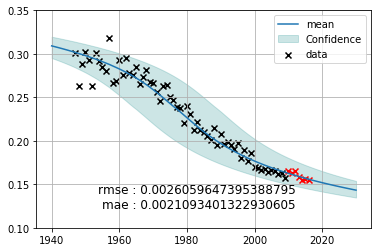

  5%|▍         | 61/1296 [05:24<2:54:33,  8.48s/it]

0.0026059647395388795 0.0021093401322930605
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sa', 2))
params:[-8.00711662e-02  1.57470234e+02]


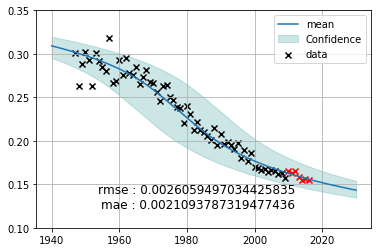

  5%|▍         | 62/1296 [05:26<2:09:22,  6.29s/it]

0.0026059497034425835 0.0021093787319477436
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sal', 1))


  5%|▍         | 63/1296 [05:28<1:43:16,  5.03s/it]

params:[-1.07453071e-01  2.12848928e+02]
0.005775332175986557 0.00518769452416359
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sal', 2))


  5%|▍         | 64/1296 [05:38<2:14:07,  6.53s/it]

params:[-9.99078939e-02  1.97974524e+02]
0.003422638050835959 0.0026921951634911534
(('sa', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 1))
params:[-8.54987276e-02  1.66714774e+02]


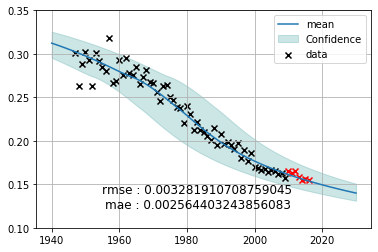

  5%|▌         | 65/1296 [05:39<1:40:14,  4.89s/it]

0.003281910708759045 0.002564403243856083
(('sa', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


  5%|▌         | 66/1296 [05:40<1:14:58,  3.66s/it]

params:[-7.97334261e-02  1.54248087e+02]
0.004250994190168096 0.0035514830164088884
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sa', 1))
params:[-7.25098229e-02  1.41794061e+02]


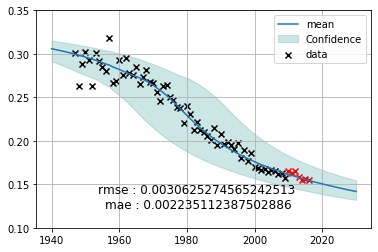

  5%|▌         | 67/1296 [05:41<1:00:43,  2.96s/it]

0.0030625274565242513 0.002235112387502886
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sa', 2))
params:[-7.25100519e-02  1.41794514e+02]


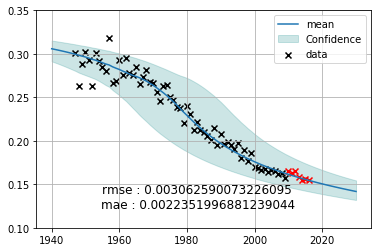

  5%|▌         | 68/1296 [05:42<49:04,  2.40s/it]  

0.003062590073226095 0.0022351996881239044
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sal', 1))


  5%|▌         | 69/1296 [05:43<42:15,  2.07s/it]

params:[-1.00627116e-01  1.99417473e+02]
0.0039473131691467305 0.002919697124027787
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sal', 2))


  5%|▌         | 70/1296 [05:57<1:56:51,  5.72s/it]

params:[-1.00529614e-01  1.99190629e+02]
0.0038895767073966205 0.0029716328745332215
(('sa', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


  5%|▌         | 71/1296 [05:58<1:26:19,  4.23s/it]

params:[-7.86418103e-02  1.52101678e+02]
0.003739815596800645 0.0030115979256218222
(('sa', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


  6%|▌         | 72/1296 [05:59<1:04:54,  3.18s/it]

params:[-6.92291942e-02  1.32482670e+02]
0.004587999288463636 0.0039400989346216565
(('sa', 1), ('sal', 1), ('sa', 1), ('sa', 1))


  6%|▌         | 73/1296 [06:00<51:23,  2.52s/it]  

params:[-1.03508463e-01  2.05013474e+02]
0.00600190101009038 0.005460185054797589
(('sa', 1), ('sal', 1), ('sa', 1), ('sa', 2))


  6%|▌         | 74/1296 [06:01<42:57,  2.11s/it]

params:[-1.03503073e-01  2.05002750e+02]
0.0060010316210923256 0.0054591399369397975
(('sa', 1), ('sal', 1), ('sa', 1), ('sal', 1))


  6%|▌         | 75/1296 [06:02<37:55,  1.86s/it]

params:[-9.69718816e-02  1.91997695e+02]
0.004705520856911588 0.003764815008731635
(('sa', 1), ('sal', 1), ('sa', 1), ('sal', 2))


  6%|▌         | 76/1296 [06:15<1:44:53,  5.16s/it]

params:[-1.04108075e-01  2.06080436e+02]
0.006073155452710249 0.005552155961971553
(('sa', 1), ('sal', 1), ('sa', 1), ('box_cox', 1))


  6%|▌         | 77/1296 [06:16<1:20:08,  3.94s/it]

params:[-1.02649681e-01  2.02401529e+02]
0.004881740908772181 0.003996532772288001
(('sa', 1), ('sal', 1), ('sa', 1), ('box_cox', 2))


  6%|▌         | 78/1296 [06:17<1:01:29,  3.03s/it]

params:[-1.03753503e-01  2.03560518e+02]
0.004829687207299807 0.0039543584165697265
(('sa', 1), ('sal', 1), ('sa', 2), ('sa', 1))


  6%|▌         | 79/1296 [06:18<48:51,  2.41s/it]  

params:[-1.03508720e-01  2.05013974e+02]
0.006001951537749633 0.0054602468972285035
(('sa', 1), ('sal', 1), ('sa', 2), ('sa', 2))


  6%|▌         | 80/1296 [06:20<43:19,  2.14s/it]

params:[-1.03507812e-01  2.05012191e+02]
0.006001762021613871 0.0054600170005909155
(('sa', 1), ('sal', 1), ('sa', 2), ('sal', 1))


  6%|▋         | 81/1296 [06:21<37:31,  1.85s/it]

params:[-9.69730083e-02  1.91999927e+02]
0.004705631524650844 0.003764985646646802
(('sa', 1), ('sal', 1), ('sa', 2), ('sal', 2))


  6%|▋         | 82/1296 [06:34<1:43:11,  5.10s/it]

params:[-4.30242132e+00  8.93121917e+03]
0.013312966541979682 0.013122094294963863
(('sa', 1), ('sal', 1), ('sa', 2), ('box_cox', 1))


  6%|▋         | 83/1296 [06:35<1:18:21,  3.88s/it]

params:[-1.02648468e-01  2.02399170e+02]
0.004880668616924311 0.003995006249943605
(('sa', 1), ('sal', 1), ('sa', 2), ('box_cox', 2))


  6%|▋         | 84/1296 [06:36<1:03:52,  3.16s/it]

params:[-1.03752100e-01  2.03557734e+02]
0.0048295999987616745 0.003954231502821414
(('sa', 1), ('sal', 1), ('sal', 1), ('sa', 1))


  7%|▋         | 85/1296 [06:37<51:46,  2.56s/it]  

params:[-9.68706262e-02  1.91796822e+02]
0.004709655594393118 0.0037707268399043386
(('sa', 1), ('sal', 1), ('sal', 1), ('sa', 2))


  7%|▋         | 86/1296 [06:39<44:24,  2.20s/it]

params:[-9.68704583e-02  1.91796459e+02]
0.004709743505030229 0.0037708651540908117
(('sa', 1), ('sal', 1), ('sal', 1), ('sal', 1))


  7%|▋         | 87/1296 [06:40<39:27,  1.96s/it]

params:[-9.76587173e-02  1.93361274e+02]
0.004847174418353587 0.003968626617807768
(('sa', 1), ('sal', 1), ('sal', 1), ('sal', 2))


  7%|▋         | 88/1296 [07:06<3:06:50,  9.28s/it]

params:[-9.27518272e-02  1.84189217e+02]
0.004492176526774105 0.003425713255131607
(('sa', 1), ('sal', 1), ('sal', 1), ('box_cox', 1))


  7%|▋         | 89/1296 [07:07<2:17:18,  6.83s/it]

params:[-9.56440473e-02  1.88452197e+02]
0.0039587653357687795 0.002906248635940602
(('sa', 1), ('sal', 1), ('sal', 1), ('box_cox', 2))


  7%|▋         | 90/1296 [07:09<1:43:06,  5.13s/it]

params:[-9.70184930e-02  1.90119371e+02]
0.0038997518244585083 0.002889788672270188
(('sa', 1), ('sal', 1), ('sal', 2), ('sa', 1))


  7%|▋         | 91/1296 [07:17<1:59:29,  5.95s/it]

params:[-9.25165881e-02  1.83140841e+02]
0.004068470318418612 0.0030348612745593234
(('sa', 1), ('sal', 1), ('sal', 2), ('sa', 2))


  7%|▋         | 92/1296 [07:36<3:19:40,  9.95s/it]

params:[-1.00478919e-01  1.98879016e+02]
0.005484789584724963 0.004837088431541776
(('sa', 1), ('sal', 1), ('sal', 2), ('sal', 1))


  7%|▋         | 93/1296 [07:44<3:09:03,  9.43s/it]

params:[-1.01246390e-01  2.00575593e+02]
0.004167795475565952 0.0031850986932262437
(('sa', 1), ('sal', 1), ('sal', 2), ('sal', 2))


  7%|▋         | 94/1296 [08:05<4:18:52, 12.92s/it]

params:[-9.92503546e-02  1.96651513e+02]
0.0040063591099880535 0.002961933968677432
(('sa', 1), ('sal', 1), ('sal', 2), ('box_cox', 1))


  7%|▋         | 95/1296 [08:08<3:19:09,  9.95s/it]

params:[ 1.78773095e-02 -3.24671782e+01]
0.07334141410326499 0.07291585323085703
(('sa', 1), ('sal', 1), ('sal', 2), ('box_cox', 2))


  7%|▋         | 96/1296 [08:18<3:18:19,  9.92s/it]

params:[-9.68923686e-02  1.89827940e+02]
0.004124106119037363 0.003182121975736022
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sa', 1))


  7%|▋         | 97/1296 [08:19<2:24:37,  7.24s/it]

params:[-9.50466334e-02  1.87725939e+02]
0.004724638682655414 0.003946609027430373
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sa', 2))


  8%|▊         | 98/1296 [08:20<1:49:46,  5.50s/it]

params:[-9.50451175e-02  1.87722929e+02]
0.004724262179310893 0.003946113742707619
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sal', 1))


  8%|▊         | 99/1296 [08:21<1:23:16,  4.17s/it]

params:[-1.01450129e-01  2.00860289e+02]
0.005498542088916882 0.004837977674750614
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sal', 2))


  8%|▊         | 100/1296 [08:49<3:41:18, 11.10s/it]

params:[-1.00246251e-01  1.98856418e+02]
0.004924838567455209 0.004083586403690799
(('sa', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 1))


  8%|▊         | 101/1296 [08:50<2:41:09,  8.09s/it]

params:[-1.02404958e-01  2.00860030e+02]
0.005158700343877261 0.004392622279355242
(('sa', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


  8%|▊         | 102/1296 [08:51<1:59:49,  6.02s/it]

params:[-9.77581382e-02  1.90488863e+02]
0.005786460248427627 0.005407336262752959
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sa', 1))


  8%|▊         | 103/1296 [08:52<1:32:02,  4.63s/it]

params:[-8.73688735e-02  1.71895631e+02]
0.004287342917941016 0.0036585961496512975
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sa', 2))


  8%|▊         | 104/1296 [08:53<1:10:44,  3.56s/it]

params:[-8.73671528e-02  1.71892167e+02]
0.004286935102960843 0.003658079924180788
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sal', 1))


  8%|▊         | 105/1296 [08:55<56:45,  2.86s/it]  

params:[-1.07938017e-01  2.13749966e+02]
0.006063356988057318 0.005545310315989641
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sal', 2))


  8%|▊         | 106/1296 [09:06<1:44:48,  5.28s/it]

params:[-1.02049489e-01  2.02356904e+02]
0.003731937373768122 0.002869122472002205
(('sa', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


  8%|▊         | 107/1296 [09:07<1:19:22,  4.01s/it]

params:[-9.89516424e-02  1.92847905e+02]
0.006802322427242331 0.006492808953407124
(('sa', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


  8%|▊         | 108/1296 [09:08<1:03:25,  3.20s/it]

params:[-8.63737434e-02  1.66908462e+02]
0.009696048010434577 0.009502846755184424
(('sa', 1), ('sal', 2), ('sa', 1), ('sa', 1))


  8%|▊         | 109/1296 [09:30<2:53:17,  8.76s/it]

params:[-1.05332833e-01  2.08341670e+02]
0.005617531412108451 0.005068320630745364
(('sa', 1), ('sal', 2), ('sa', 1), ('sa', 2))


  8%|▊         | 110/1296 [09:35<2:30:09,  7.60s/it]

params:[-1.02429703e-01  2.02869327e+02]
0.004896294493080465 0.0040234561789613465
(('sa', 1), ('sal', 2), ('sa', 1), ('sal', 1))


  9%|▊         | 111/1296 [09:43<2:33:20,  7.76s/it]

params:[-9.59001977e-02  1.89998627e+02]
0.003958014045131845 0.003077898824621137
(('sa', 1), ('sal', 2), ('sa', 1), ('sal', 2))


  9%|▊         | 112/1296 [10:17<5:07:56, 15.60s/it]

params:[-1.01256537e-01  2.00662207e+02]
0.0035934775880264603 0.0026887276728254994
(('sa', 1), ('sal', 2), ('sa', 1), ('box_cox', 1))


  9%|▊         | 113/1296 [10:22<4:07:38, 12.56s/it]

params:[-8.56530872e-02  1.68178400e+02]
0.0037513719668535437 0.002758604799933379
(('sa', 1), ('sal', 2), ('sa', 1), ('box_cox', 2))
params:[-8.34465392e-02  1.62853514e+02]


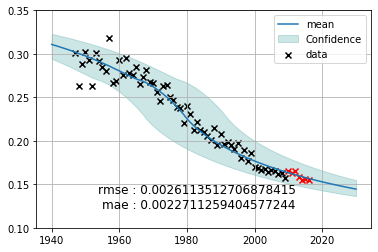

  9%|▉         | 114/1296 [10:35<4:07:20, 12.56s/it]

0.0026113512706878415 0.0022711259404577244
(('sa', 1), ('sal', 2), ('sa', 2), ('sa', 1))


  9%|▉         | 115/1296 [10:58<5:12:01, 15.85s/it]

params:[-1.01702108e-01  2.01459564e+02]
0.003751955804758968 0.0027738443743386015
(('sa', 1), ('sal', 2), ('sa', 2), ('sa', 2))


  9%|▉         | 116/1296 [11:06<4:22:48, 13.36s/it]

params:[-1.03386989e-01  2.04775232e+02]
0.005275074374776161 0.0045352624479069415
(('sa', 1), ('sal', 2), ('sa', 2), ('sal', 1))


  9%|▉         | 117/1296 [11:20<4:25:30, 13.51s/it]

params:[-1.01519824e-01  2.01094282e+02]
0.003929327380142091 0.0029792347320927526
(('sa', 1), ('sal', 2), ('sa', 2), ('sal', 2))


  9%|▉         | 118/1296 [11:40<5:06:23, 15.61s/it]

params:[-1.01719065e-01  2.01515305e+02]
0.003837109137305405 0.002838915500503525
(('sa', 1), ('sal', 2), ('sa', 2), ('box_cox', 1))


  9%|▉         | 119/1296 [11:43<3:50:09, 11.73s/it]

params:[-8.46935026e-02  1.66384354e+02]
0.0035660111089514715 0.002832853327141604
(('sa', 1), ('sal', 2), ('sa', 2), ('box_cox', 2))


  9%|▉         | 120/1296 [11:48<3:14:39,  9.93s/it]

params:[-9.99928140e-02  1.96178412e+02]
0.0037063092676594836 0.002787341170862795
(('sa', 1), ('sal', 2), ('sal', 1), ('sa', 1))


  9%|▉         | 121/1296 [12:01<3:32:20, 10.84s/it]

params:[-1.14177285e-01  2.26206405e+02]
0.008066019056775528 0.007792628227516145
(('sa', 1), ('sal', 2), ('sal', 1), ('sa', 2))


  9%|▉         | 122/1296 [12:12<3:33:16, 10.90s/it]

params:[-1.01611131e-01  2.01289533e+02]
0.003948063197245079 0.0029763681764844807
(('sa', 1), ('sal', 2), ('sal', 1), ('sal', 1))


  9%|▉         | 123/1296 [12:19<3:06:32,  9.54s/it]

params:[-9.90973490e-02  1.96249148e+02]
0.00450441728358123 0.0035314224749549545
(('sa', 1), ('sal', 2), ('sal', 1), ('sal', 2))


 10%|▉         | 124/1296 [12:34<3:40:59, 11.31s/it]

params:[-7.79520743e-02  1.52745365e+02]
0.014262532854471897 0.014012266790495474
(('sa', 1), ('sal', 2), ('sal', 1), ('box_cox', 1))


 10%|▉         | 125/1296 [12:39<3:02:32,  9.35s/it]

params:[-9.84278488e-02  1.94010232e+02]
0.00390674851960669 0.0028900470360332347
(('sa', 1), ('sal', 2), ('sal', 1), ('box_cox', 2))


 10%|▉         | 126/1296 [12:43<2:32:14,  7.81s/it]

params:[-1.08215479e-01  2.12326777e+02]
0.004310302573949644 0.0037440447311746505
(('sa', 1), ('sal', 2), ('sal', 2), ('sa', 1))


 10%|▉         | 127/1296 [12:54<2:51:42,  8.81s/it]

params:[-1.15829973e-01  2.28505967e+02]
0.014001326253758021 0.013871783853274203
(('sa', 1), ('sal', 2), ('sal', 2), ('sa', 2))


 10%|▉         | 128/1296 [13:12<3:45:02, 11.56s/it]

params:[-1.15667994e-01  2.29795176e+02]
0.004131997623922213 0.0031583817719651624
(('sa', 1), ('sal', 2), ('sal', 2), ('sal', 1))


 10%|▉         | 129/1296 [13:42<5:32:41, 17.10s/it]

params:[-9.89577441e-02  1.96079012e+02]
0.0038945374576326787 0.0030305536415337025
(('sa', 1), ('sal', 2), ('sal', 2), ('sal', 2))


 10%|█         | 130/1296 [14:28<8:18:56, 25.67s/it]

params:[-1.02611234e-01  2.03274838e+02]
0.0038569074521199774 0.002908961608292721
(('sa', 1), ('sal', 2), ('sal', 2), ('box_cox', 1))


 10%|█         | 131/1296 [14:52<8:08:09, 25.14s/it]

params:[ 1.38112931e-02 -2.37239755e+01]
0.03616814189515497 0.035574657979320204
(('sa', 1), ('sal', 2), ('sal', 2), ('box_cox', 2))


 10%|█         | 132/1296 [15:16<8:02:26, 24.87s/it]

params:[-1.01568352e-01  1.99255006e+02]
0.003618848715909457 0.0026772238104538254
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sa', 1))
params:[-9.67164842e-02  1.91184629e+02]


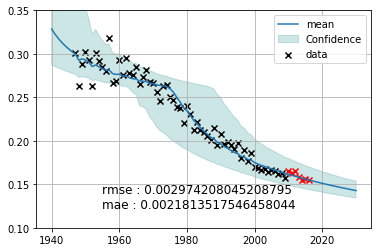

 10%|█         | 133/1296 [15:34<7:18:52, 22.64s/it]

0.002974208045208795 0.0021813517546458044
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sa', 2))


 10%|█         | 134/1296 [15:46<6:17:14, 19.48s/it]

params:[ 3.84833641e-02 -7.67376955e+01]
0.07882792843411539 0.07819818076137781
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sal', 1))


 10%|█         | 135/1296 [15:59<5:41:39, 17.66s/it]

params:[-9.99518794e-02  1.97989404e+02]
0.004240124929491343 0.0032342552034527144
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sal', 2))
params:[-9.18418722e+06  2.69286094e+10]


 10%|█         | 136/1296 [17:47<14:22:20, 44.60s/it]

0.33590745944900036 0.33589832894545246
(('sa', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 11%|█         | 137/1296 [17:56<10:56:21, 33.98s/it]

params:[-1.02076175e-01  2.00204604e+02]
0.004684092363600523 0.0037487723245974635
(('sa', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2))


 11%|█         | 138/1296 [18:09<8:52:26, 27.59s/it] 

params:[-9.72047028e-02  1.89614990e+02]
0.0035609486799135634 0.0028376882067265574
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sa', 1))


 11%|█         | 139/1296 [18:12<6:32:48, 20.37s/it]

params:[-8.43695773e-02  1.66837971e+02]
0.0035111609145314134 0.0028854623370860983
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sa', 2))


 11%|█         | 140/1296 [18:19<5:14:50, 16.34s/it]

params:[-8.34910616e-02  1.64269531e+02]
0.004240594622682965 0.0031209814920570766
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sal', 1))


 11%|█         | 141/1296 [18:32<4:56:53, 15.42s/it]

params:[-9.70484174e-02  1.92340259e+02]
0.003442727194567075 0.0028432471224592265
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sal', 2))
params:[-1.50896492e+08  3.00371365e+11]


 11%|█         | 142/1296 [19:04<6:30:41, 20.31s/it]

0.004253632330599677 0.003707564978543009
(('sa', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 1))
params:[-9.98112017e-02  1.94698576e+02]


 11%|█         | 143/1296 [19:28<6:49:48, 21.33s/it]

0.004586170802877682 0.0038940545168780483
(('sa', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 11%|█         | 144/1296 [19:37<5:39:26, 17.68s/it]

params:[-8.63555782e-02  1.66916619e+02]
0.007971755706429228 0.007703095039771957
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))
params:[-8.00715759e-02  1.57471039e+02]


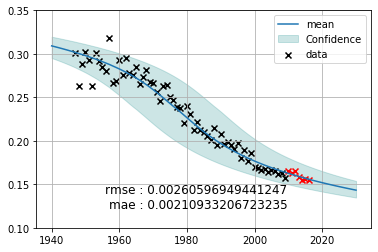

 11%|█         | 145/1296 [19:38<4:01:37, 12.60s/it]

0.00260596949441247 0.00210933206723235
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 2))
params:[-8.00716256e-02  1.57471138e+02]


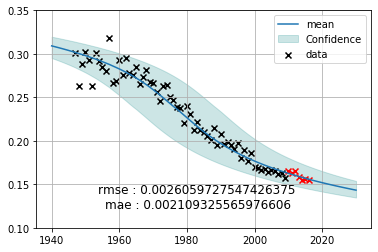

 11%|█▏        | 146/1296 [19:38<2:53:37,  9.06s/it]

0.0026059727547426375 0.002109325565976606
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sal', 1))


 11%|█▏        | 147/1296 [19:39<2:06:40,  6.62s/it]

params:[-1.07451029e-01  2.12844814e+02]
0.0057750509555702005 0.005187347056046613
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sal', 2))
params:[-3.08649743e+02  6.13600113e+05]


 11%|█▏        | 148/1296 [19:59<3:21:32, 10.53s/it]

0.0760381784375352 0.07600448139707705
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 11%|█▏        | 149/1296 [19:59<2:23:19,  7.50s/it]

params:[-8.15962255e-02  1.59351826e+02]
0.00393293664611938 0.003198329177691754
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 12%|█▏        | 150/1296 [20:00<1:43:40,  5.43s/it]

params:[-7.83337100e-02  1.51873336e+02]
0.00433820772429225 0.0036351540711806185
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sa', 1))
params:[-8.00713639e-02  1.57470621e+02]


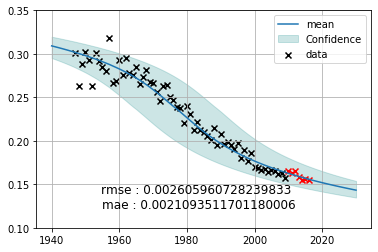

 12%|█▏        | 151/1296 [20:01<1:17:04,  4.04s/it]

0.002605960728239833 0.0021093511701180006
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sa', 2))
params:[-8.00715054e-02  1.57470904e+02]


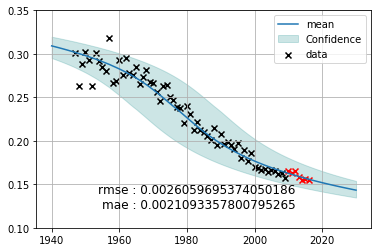

 12%|█▏        | 152/1296 [20:02<58:40,  3.08s/it]  

0.0026059695374050186 0.0021093357800795265
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sal', 1))


 12%|█▏        | 153/1296 [20:03<47:10,  2.48s/it]

params:[-1.07452718e-01  2.12848181e+02]
0.005775160529593212 0.005187472830450667
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sal', 2))
params:[-3.45641355e+11  6.79489035e+14]


 12%|█▏        | 154/1296 [20:07<59:11,  3.11s/it]

0.008810166880501014 0.007780395117541044
(('sa', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 12%|█▏        | 155/1296 [20:08<44:52,  2.36s/it]

params:[-8.15963391e-02  1.59352049e+02]
0.003932979685398528 0.003198369558847665
(('sa', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 12%|█▏        | 156/1296 [20:09<38:01,  2.00s/it]

params:[-7.83337144e-02  1.51873332e+02]
0.004338181896371772 0.0036351211576490356
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sa', 1))


 12%|█▏        | 157/1296 [20:10<32:24,  1.71s/it]

params:[-1.08933936e-01  2.15784625e+02]
0.005713892220802376 0.005112856094723213
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sa', 2))


 12%|█▏        | 158/1296 [20:11<29:19,  1.55s/it]

params:[-1.08935243e-01  2.15787143e+02]
0.005714152403335754 0.005113188835625663
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sal', 1))


 12%|█▏        | 159/1296 [20:13<27:39,  1.46s/it]

params:[-9.92516688e-02  1.96597913e+02]
0.003997315656530166 0.002987980559818086
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sal', 2))


 12%|█▏        | 160/1296 [20:25<1:27:51,  4.64s/it]

params:[-9.16754991e-02  1.81896977e+02]
0.003681549678724582 0.0030391772996324617
(('sa', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 12%|█▏        | 161/1296 [20:26<1:06:58,  3.54s/it]

params:[-1.07235837e-01  2.11578478e+02]
0.004116274865127213 0.0031326786832977555
(('sa', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 12%|█▎        | 162/1296 [20:27<52:35,  2.78s/it]  

params:[-1.08424579e-01  2.12907365e+02]
0.004254664153090646 0.0033224789656508785
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sa', 1))
params:[-8.07741169e-02  1.59305976e+02]


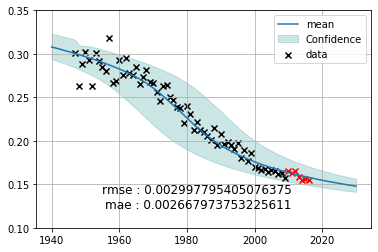

 13%|█▎        | 163/1296 [20:35<1:27:14,  4.62s/it]

0.002997795405076375 0.002667973753225611
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sa', 2))


 13%|█▎        | 164/1296 [20:42<1:36:34,  5.12s/it]

params:[-8.67003439e-02  1.70227755e+02]
0.006247530774211748 0.005826720752123514
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sal', 1))
params:[-1. -1.]


 13%|█▎        | 165/1296 [20:47<1:34:34,  5.02s/it]

0.11725316392587411 0.11716977362414911
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sal', 2))
params:[-7.24956003e+03  1.44361625e+07]


 13%|█▎        | 166/1296 [20:57<2:04:13,  6.60s/it]

0.1108607928844947 0.11083030402179697
(('sa', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 13%|█▎        | 167/1296 [21:17<3:22:34, 10.77s/it]

params:[-9.99329148e-02  1.97026712e+02]
0.0034655221684959775 0.0027749308894400027
(('sa', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 2))


 13%|█▎        | 168/1296 [21:25<3:07:26,  9.97s/it]

params:[ 2.37053751e-02 -4.28197349e+01]
0.09704912271899 0.09665211478166588
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 13%|█▎        | 169/1296 [21:26<2:13:22,  7.10s/it]

params:[-7.44659470e-02  1.45665641e+02]
0.0036956839305175154 0.002966099199213919
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 13%|█▎        | 170/1296 [21:26<1:36:43,  5.15s/it]

params:[-7.44652049e-02  1.45664185e+02]
0.003695315964292293 0.0029657371733070393
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 1))


 13%|█▎        | 171/1296 [21:27<1:11:34,  3.82s/it]

params:[-1.03240108e-01  2.04561518e+02]
0.004427602534687656 0.003477343880785478
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 13%|█▎        | 172/1296 [21:31<1:13:22,  3.92s/it]

params:[-1.00883083e-01  1.99891896e+02]
0.0035916519834898897 0.002735683707184899
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 13%|█▎        | 173/1296 [21:32<54:39,  2.92s/it]  

params:[-8.00542947e-02  1.54858311e+02]
0.0047230306921534956 0.004122415271772706
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))


 13%|█▎        | 174/1296 [21:32<41:12,  2.20s/it]

params:[-7.03663129e-02  1.34698940e+02]
0.005741697883889244 0.0052869673955841445
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 1))
params:[-6.77994277e-02  1.32142966e+02]


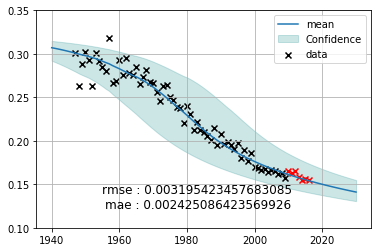

 14%|█▎        | 175/1296 [21:33<33:13,  1.78s/it]

0.003195423457683085 0.002425086423569926
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 2))
params:[-6.77985686e-02  1.32141305e+02]


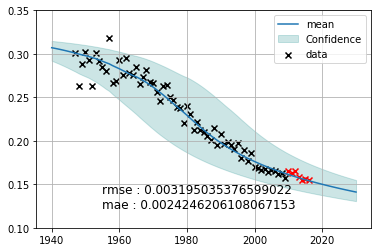

 14%|█▎        | 176/1296 [21:34<27:56,  1.50s/it]

0.003195035376599022 0.0024246206108067153
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 14%|█▎        | 177/1296 [21:35<26:09,  1.40s/it]

params:[-9.80892152e-02  1.94496829e+02]
0.004077399546660808 0.0029978816898650696
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 2))


 14%|█▎        | 178/1296 [22:08<3:22:46, 10.88s/it]

params:[-1.05392558e-01  2.08703754e+02]
0.003653402752656956 0.0029501551861774644
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 14%|█▍        | 179/1296 [22:09<2:24:51,  7.78s/it]

params:[-6.95182105e-02  1.33020977e+02]
0.005599152385653996 0.0051274128804049334
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 14%|█▍        | 180/1296 [22:10<1:46:22,  5.72s/it]

params:[-5.77661705e-02  1.08919478e+02]
0.0064156027708725544 0.006027235654395597
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sa', 1))
params:[-7.25100098e-02  1.41794433e+02]


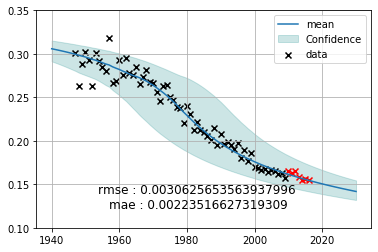

 14%|█▍        | 181/1296 [22:10<1:18:33,  4.23s/it]

0.0030625653563937996 0.00223516627319309
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sa', 2))
params:[-7.25101817e-02  1.41794768e+02]


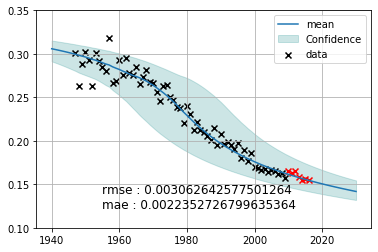

 14%|█▍        | 182/1296 [22:12<1:03:44,  3.43s/it]

0.003062642577501264 0.0022352726799635364
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sal', 1))


 14%|█▍        | 183/1296 [22:16<1:06:43,  3.60s/it]

params:[-1.00627214e-01  1.99417684e+02]
0.003947311590253982 0.0029196932425836646
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sal', 2))


 14%|█▍        | 184/1296 [22:41<3:04:18,  9.94s/it]

params:[-1.00673620e-01  1.99468783e+02]
0.0038232394712562267 0.0029206165005094026
(('sa', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 1))
params:[-7.2950992e-02  1.4169038e+02]


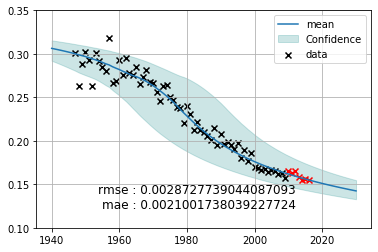

 14%|█▍        | 185/1296 [22:42<2:13:22,  7.20s/it]

0.0028727739044087093 0.0021001738039227724
(('sa', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 2))
params:[-7.13478023e-02  1.37479118e+02]


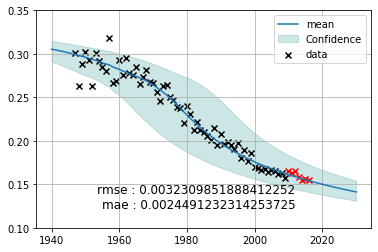

 14%|█▍        | 186/1296 [22:43<1:42:59,  5.57s/it]

0.0032309851888412252 0.0024491232314253725
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sa', 1))
params:[-7.25101771e-02  1.41794750e+02]


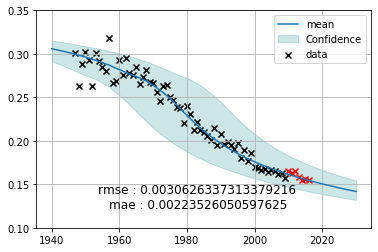

 14%|█▍        | 187/1296 [22:45<1:20:45,  4.37s/it]

0.0030626337313379216 0.00223526050597625
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sa', 2))
params:[-7.25091163e-02  1.41792672e+02]


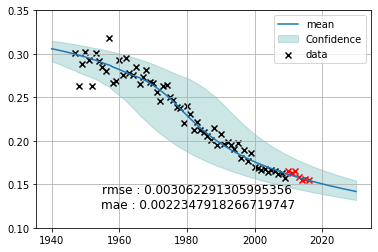

 15%|█▍        | 188/1296 [22:46<1:01:49,  3.35s/it]

0.003062291305995356 0.0022347918266719747
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sal', 1))
params:[-1. -1.]


 15%|█▍        | 189/1296 [22:47<48:58,  2.65s/it]  

4.616669388440256 4.616667323807787
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sal', 2))


 15%|█▍        | 190/1296 [23:02<1:56:23,  6.31s/it]

params:[-1.02118648e-01  2.02355908e+02]
0.003913124892623635 0.0029539263603811294
(('sa', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 1))
params:[-7.29511246e-02  1.41690627e+02]


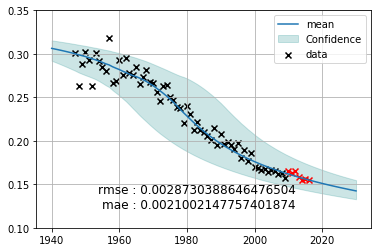

 15%|█▍        | 191/1296 [23:04<1:31:52,  4.99s/it]

0.0028730388646476504 0.0021002147757401874
(('sa', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 2))
params:[-7.13469896e-02  1.37477528e+02]


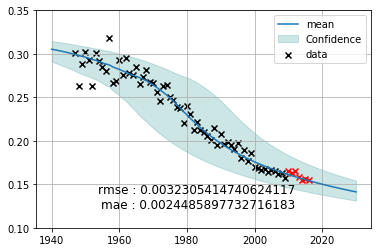

 15%|█▍        | 192/1296 [23:06<1:16:32,  4.16s/it]

0.0032305414740624117 0.0024485897732716183
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sa', 1))


 15%|█▍        | 193/1296 [23:09<1:09:18,  3.77s/it]

params:[-1.00864672e-01  1.99916741e+02]
0.0039437468326578564 0.0029340414702372325
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sa', 2))


 15%|█▍        | 194/1296 [23:10<53:56,  2.94s/it]  

params:[-1.00865132e-01  1.99917619e+02]
0.0039437717492370045 0.0029340926284599895
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sal', 1))


 15%|█▌        | 195/1296 [23:11<43:54,  2.39s/it]

params:[-1.00366554e-01  1.98803065e+02]
0.003844366741983253 0.002865331853337879
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sal', 2))
params:[-1.00306134e+09  2.00070199e+12]


 15%|█▌        | 196/1296 [23:19<1:14:04,  4.04s/it]

0.5215115664356476 0.5214722139260936
(('sa', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 15%|█▌        | 197/1296 [23:20<58:06,  3.17s/it]  

params:[-9.98243311e-02  1.96916204e+02]
0.0034926621257317307 0.0028363666594341213
(('sa', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 15%|█▌        | 198/1296 [23:21<45:27,  2.48s/it]

params:[-1.00998275e-01  1.98208383e+02]
0.0034504446617633264 0.002725356215278129
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sa', 1))


 15%|█▌        | 199/1296 [23:37<2:01:16,  6.63s/it]

params:[-1.00886942e-01  1.99886436e+02]
0.0037245819117753135 0.002847844591115411
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sa', 2))


 15%|█▌        | 200/1296 [23:40<1:38:51,  5.41s/it]

params:[-7.34553803e-02  1.43632427e+02]
0.003650634995638808 0.002858602319250142
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sal', 1))
params:[-2.05949822e+03  4.10638721e+06]


 16%|█▌        | 201/1296 [23:44<1:32:36,  5.07s/it]

0.31822583506039515 0.31821544321973194
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sal', 2))


 16%|█▌        | 202/1296 [24:07<3:09:31, 10.39s/it]

params:[-9.71207261e-02  1.92500649e+02]
0.003687347599520167 0.002965322835132289
(('sa', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 1))


 16%|█▌        | 203/1296 [24:14<2:52:52,  9.49s/it]

params:[ 7.27260561e-03 -1.16381453e+01]
0.1133340354019677 0.11323939956075847
(('sa', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 2))
params:[-1.00357158e-01  1.96955235e+02]


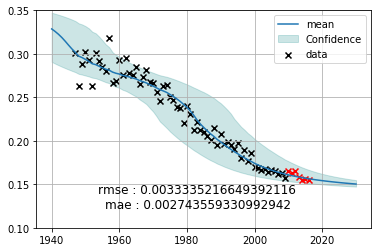

 16%|█▌        | 204/1296 [24:23<2:50:36,  9.37s/it]

0.0033335216649392116 0.002743559330992942
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 1))
params:[-6.62982727e-02  1.29126670e+02]


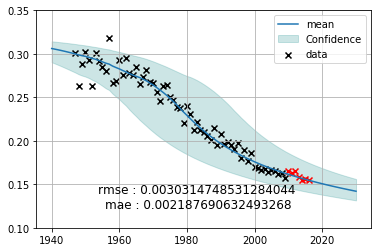

 16%|█▌        | 205/1296 [24:24<2:03:49,  6.81s/it]

0.0030314748531284044 0.002187690632493268
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 2))
params:[-6.62986467e-02  1.29127375e+02]


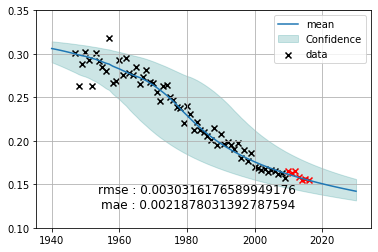

 16%|█▌        | 206/1296 [24:25<1:31:32,  5.04s/it]

0.0030316176589949176 0.0021878031392787594
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 1))


 16%|█▌        | 207/1296 [24:26<1:09:03,  3.81s/it]

params:[-9.60461639e-02  1.90477509e+02]
0.0038420713283121633 0.0029954989594674236
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 2))
params:[-8.29101398e-02  1.63267941e+02]


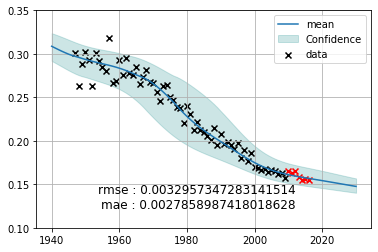

 16%|█▌        | 208/1296 [24:27<56:39,  3.12s/it]  

0.0032957347283141514 0.0027858987418018628
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 1))


 16%|█▌        | 209/1296 [24:28<42:04,  2.32s/it]

params:[-6.87325119e-02  1.31478409e+02]
0.0049491856097557355 0.004366532343907163
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 2))


 16%|█▌        | 210/1296 [24:29<33:15,  1.84s/it]

params:[-5.71354697e-02  1.07681383e+02]
0.0057109523020246085 0.005237225073552022
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 1))
params:[-6.37626353e-02  1.24123439e+02]


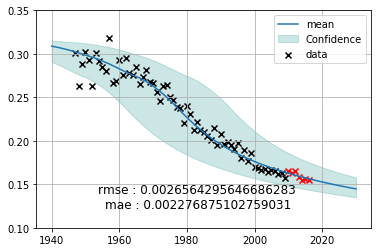

 16%|█▋        | 211/1296 [24:29<27:22,  1.51s/it]

0.0026564295646686283 0.002276875102759031
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 2))
params:[-6.37620773e-02  1.24122322e+02]


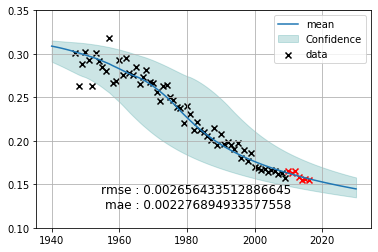

 16%|█▋        | 212/1296 [24:30<23:39,  1.31s/it]

0.002656433512886645 0.002276894933577558
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 1))


 16%|█▋        | 213/1296 [24:31<21:25,  1.19s/it]

params:[-9.31922127e-02  1.84885472e+02]
0.0038963798744693742 0.003080258404397538
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 2))


 17%|█▋        | 214/1296 [24:41<1:10:56,  3.93s/it]

params:[-8.67762693e+00  1.69542088e+04]
0.0041621088777447895 0.003278436745576727
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 1))


 17%|█▋        | 215/1296 [24:42<53:08,  2.95s/it]  

params:[-5.54693307e-02  1.04382480e+02]
0.0057826450105019815 0.005318187428508243
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 2))


 17%|█▋        | 216/1296 [24:43<40:36,  2.26s/it]

params:[-4.41964907e-02  8.13999826e+01]
0.0064392901062524325 0.006041322251646283
(('sa', 2), ('sa', 1), ('sa', 1), ('sa', 1))


 17%|█▋        | 217/1296 [24:43<32:09,  1.79s/it]

params:[-8.43707770e-02  1.66682004e+02]
0.0035603663929502315 0.0027990448135355095
(('sa', 2), ('sa', 1), ('sa', 1), ('sa', 2))


 17%|█▋        | 218/1296 [24:44<27:12,  1.51s/it]

params:[-8.43707903e-02  1.66682032e+02]
0.00356036335698897 0.0027990434326126768
(('sa', 2), ('sa', 1), ('sa', 1), ('sal', 1))


 17%|█▋        | 219/1296 [24:45<24:27,  1.36s/it]

params:[-1.02581243e-01  2.03164106e+02]
0.006030431346819736 0.00549354292817452
(('sa', 2), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-7.61420210e+01  1.49533465e+05]


 17%|█▋        | 220/1296 [24:52<53:22,  2.98s/it]

0.004357574737036461 0.003241975793107096
(('sa', 2), ('sa', 1), ('sa', 1), ('box_cox', 1))


 17%|█▋        | 221/1296 [24:53<40:30,  2.26s/it]

params:[-8.55311583e-02  1.67938325e+02]
0.003735082086031283 0.0027608582763797096
(('sa', 2), ('sa', 1), ('sa', 1), ('box_cox', 2))
params:[-8.39187221e-02  1.63633572e+02]


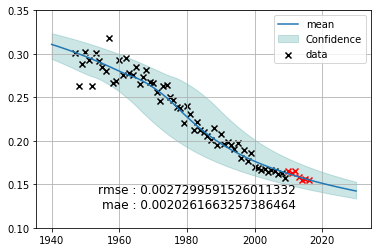

 17%|█▋        | 222/1296 [24:53<33:09,  1.85s/it]

0.0027299591526011332 0.0020261663257386464
(('sa', 2), ('sa', 1), ('sa', 2), ('sa', 1))


 17%|█▋        | 223/1296 [24:54<28:16,  1.58s/it]

params:[-8.43707839e-02  1.66682019e+02]
0.0035603629378223836 0.0027990431382660702
(('sa', 2), ('sa', 1), ('sa', 2), ('sa', 2))


 17%|█▋        | 224/1296 [24:56<25:50,  1.45s/it]

params:[-8.43709059e-02  1.66682262e+02]
0.0035603579835469 0.002799042232611067
(('sa', 2), ('sa', 1), ('sa', 2), ('sal', 1))


 17%|█▋        | 225/1296 [24:57<23:43,  1.33s/it]

params:[-1.02580710e-01  2.03163036e+02]
0.006030281917412762 0.005493363516669113
(('sa', 2), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-2.64346556e+04  5.18576735e+07]


 17%|█▋        | 226/1296 [25:08<1:16:30,  4.29s/it]

0.005885206031676085 0.004999103263131193
(('sa', 2), ('sa', 1), ('sa', 2), ('box_cox', 1))


 18%|█▊        | 227/1296 [25:09<57:33,  3.23s/it]  

params:[-8.55309908e-02  1.67937999e+02]
0.0037350821896938876 0.002760853368614571
(('sa', 2), ('sa', 1), ('sa', 2), ('box_cox', 2))
params:[-8.39185164e-02  1.63633184e+02]


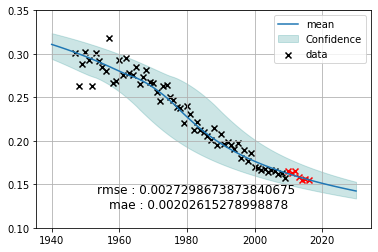

 18%|█▊        | 228/1296 [25:10<45:39,  2.57s/it]

0.0027298673873840675 0.00202615278998878
(('sa', 2), ('sa', 1), ('sal', 1), ('sa', 1))


 18%|█▊        | 229/1296 [25:11<37:23,  2.10s/it]

params:[-1.03508158e-01  2.05012895e+02]
0.006001800138325825 0.00546006140969368
(('sa', 2), ('sa', 1), ('sal', 1), ('sa', 2))


 18%|█▊        | 230/1296 [25:12<31:42,  1.78s/it]

params:[-1.03509299e-01  2.05015110e+02]
0.0060020650007398665 0.005460384652240057
(('sa', 2), ('sa', 1), ('sal', 1), ('sal', 1))


 18%|█▊        | 231/1296 [25:13<28:54,  1.63s/it]

params:[-9.69716935e-02  1.91997328e+02]
0.004705402086797022 0.0037646404041118725
(('sa', 2), ('sa', 1), ('sal', 1), ('sal', 2))


 18%|█▊        | 232/1296 [25:22<1:09:43,  3.93s/it]

params:[-9.65846199e-02  1.91221368e+02]
0.00471962412186518 0.0038032065599920084
(('sa', 2), ('sa', 1), ('sal', 1), ('box_cox', 1))


 18%|█▊        | 233/1296 [25:23<54:04,  3.05s/it]  

params:[-1.01569039e-01  2.00262215e+02]
0.0047407671643706125 0.003784174966383637
(('sa', 2), ('sa', 1), ('sal', 1), ('box_cox', 2))


 18%|█▊        | 234/1296 [25:24<43:30,  2.46s/it]

params:[-1.02752965e-01  2.01575070e+02]
0.0047046619990218945 0.0037692745160919994
(('sa', 2), ('sa', 1), ('sal', 2), ('sa', 1))


 18%|█▊        | 235/1296 [25:44<2:12:45,  7.51s/it]

params:[-1.01810273e-01  2.01757140e+02]
0.003794374683333765 0.002771985401923816
(('sa', 2), ('sa', 1), ('sal', 2), ('sa', 2))


 18%|█▊        | 236/1296 [26:05<3:28:45, 11.82s/it]

params:[-9.97273713e-02  1.97612838e+02]
0.004070608861562913 0.003038854332995405
(('sa', 2), ('sa', 1), ('sal', 2), ('sal', 1))


 18%|█▊        | 237/1296 [26:15<3:16:21, 11.13s/it]

params:[-9.55212610e-02  1.89244003e+02]
0.0041962784992187405 0.003212480543254685
(('sa', 2), ('sa', 1), ('sal', 2), ('sal', 2))


 18%|█▊        | 238/1296 [26:29<3:30:06, 11.92s/it]

params:[-1.08828968e-01  2.14799206e+02]
0.03258899676414824 0.032502052870934696
(('sa', 2), ('sa', 1), ('sal', 2), ('box_cox', 1))


 18%|█▊        | 239/1296 [26:48<4:07:07, 14.03s/it]

params:[-9.53989102e-03  2.51438455e+01]
0.02918984380189885 0.02855437603290439
(('sa', 2), ('sa', 1), ('sal', 2), ('box_cox', 2))


 19%|█▊        | 240/1296 [27:23<6:00:07, 20.46s/it]

params:[-9.95462716e-02  1.95351984e+02]
0.0037389918858801593 0.0030263810945409014
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sa', 1))
params:[-8.00714580e-02  1.57470806e+02]


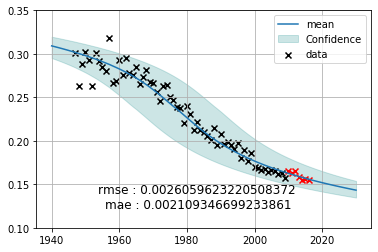

 19%|█▊        | 241/1296 [27:24<4:17:32, 14.65s/it]

0.0026059623220508372 0.002109346699233861
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sa', 2))
params:[-8.00711660e-02  1.57470231e+02]


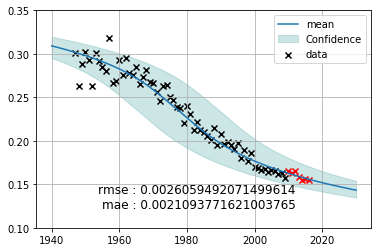

 19%|█▊        | 242/1296 [27:26<3:10:24, 10.84s/it]

0.0026059492071499614 0.0021093771621003765
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sal', 1))


 19%|█▉        | 243/1296 [27:30<2:33:45,  8.76s/it]

params:[-1.07453411e-01  2.12849531e+02]
0.005774804127178933 0.0051870247837173455
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sal', 2))
params:[-9.95961503e-02  1.97407232e+02]


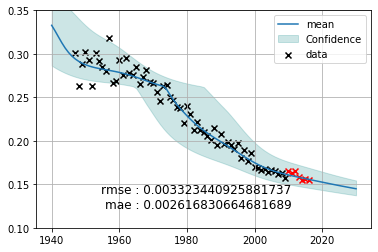

 19%|█▉        | 244/1296 [27:40<2:37:14,  8.97s/it]

0.003323440925881737 0.002616830664681689
(('sa', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 1))
params:[-8.54987346e-02  1.66714789e+02]


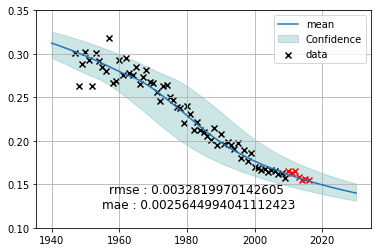

 19%|█▉        | 245/1296 [27:40<1:54:01,  6.51s/it]

0.0032819970142605 0.0025644994041112423
(('sa', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


 19%|█▉        | 246/1296 [27:41<1:24:23,  4.82s/it]

params:[-7.97336713e-02  1.54248577e+02]
0.004250963062673806 0.0035514454210387814
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sa', 1))
params:[-7.25104739e-02  1.41795347e+02]


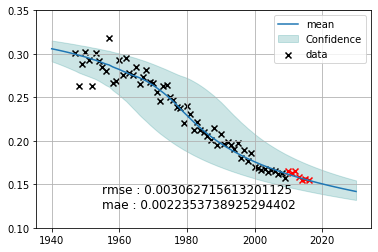

 19%|█▉        | 247/1296 [27:42<1:04:53,  3.71s/it]

0.003062715613201125 0.0022353738925294402
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sa', 2))
params:[-7.25099163e-02  1.41794244e+02]


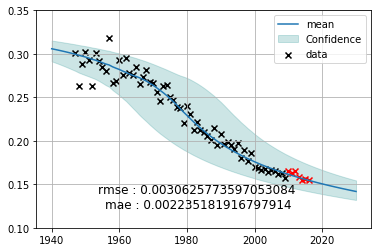

 19%|█▉        | 248/1296 [27:44<53:48,  3.08s/it]  

0.0030625773597053084 0.002235181916797914
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sal', 1))


 19%|█▉        | 249/1296 [27:45<43:19,  2.48s/it]

params:[-1.00626602e-01  1.99416453e+02]
0.0039472701204218835 0.0029196240942270324
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sal', 2))


 19%|█▉        | 250/1296 [27:52<1:07:24,  3.87s/it]

params:[-9.99853099e-02  1.98117994e+02]
0.0038481069545981857 0.0029685820316820155
(('sa', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


 19%|█▉        | 251/1296 [27:53<51:33,  2.96s/it]  

params:[-7.86417309e-02  1.52101518e+02]
0.003739880283337173 0.0030116606050446327
(('sa', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


 19%|█▉        | 252/1296 [27:54<40:13,  2.31s/it]

params:[-6.92292074e-02  1.32482698e+02]
0.004587937311559234 0.003940023252561363
(('sa', 2), ('sa', 2), ('sa', 1), ('sa', 1))


 20%|█▉        | 253/1296 [27:55<34:11,  1.97s/it]

params:[-8.43707700e-02  1.66681989e+02]
0.0035603677886688976 0.0027990454257218983
(('sa', 2), ('sa', 2), ('sa', 1), ('sa', 2))


 20%|█▉        | 254/1296 [27:56<28:52,  1.66s/it]

params:[-8.43707811e-02  1.66682010e+02]
0.0035603696862397225 0.0027990465830208693
(('sa', 2), ('sa', 2), ('sa', 1), ('sal', 1))


 20%|█▉        | 255/1296 [27:57<25:14,  1.46s/it]

params:[-1.02581410e-01  2.03164429e+02]
0.006030483234365402 0.005493606024332199
(('sa', 2), ('sa', 2), ('sa', 1), ('sal', 2))
params:[-1.73022453e+09  3.40044158e+12]


 20%|█▉        | 256/1296 [28:02<43:26,  2.51s/it]

0.010105506005313807 0.009278586633448263
(('sa', 2), ('sa', 2), ('sa', 1), ('box_cox', 1))


 20%|█▉        | 257/1296 [28:03<34:43,  2.01s/it]

params:[-8.55310752e-02  1.67938166e+02]
0.003735089482639984 0.002760850245248327
(('sa', 2), ('sa', 2), ('sa', 1), ('box_cox', 2))
params:[-8.39186431e-02  1.63633423e+02]


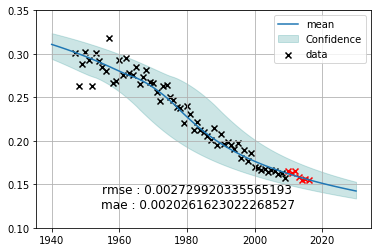

 20%|█▉        | 258/1296 [28:04<30:12,  1.75s/it]

0.002729920335565193 0.0020261623022268527
(('sa', 2), ('sa', 2), ('sa', 2), ('sa', 1))


 20%|█▉        | 259/1296 [28:05<25:37,  1.48s/it]

params:[-8.43707828e-02  1.66682017e+02]
0.0035603631812474897 0.002799043249708235
(('sa', 2), ('sa', 2), ('sa', 2), ('sa', 2))


 20%|██        | 260/1296 [28:06<24:01,  1.39s/it]

params:[-8.43707882e-02  1.66682025e+02]
0.003560367455337092 0.0027990455284092448
(('sa', 2), ('sa', 2), ('sa', 2), ('sal', 1))


 20%|██        | 261/1296 [28:08<25:25,  1.47s/it]

params:[-1.02580191e-01  2.03162006e+02]
0.006030459714098273 0.005493582508276347
(('sa', 2), ('sa', 2), ('sa', 2), ('sal', 2))


 20%|██        | 262/1296 [28:17<1:04:29,  3.74s/it]

params:[-1.03055802e-01  2.04204809e+02]
0.004123390565893013 0.0031605712895955945
(('sa', 2), ('sa', 2), ('sa', 2), ('box_cox', 1))


 20%|██        | 263/1296 [28:18<50:44,  2.95s/it]  

params:[-8.55310217e-02  1.67938059e+02]
0.0037350847680363364 0.002760853368653968
(('sa', 2), ('sa', 2), ('sa', 2), ('box_cox', 2))
params:[-8.39184874e-02  1.63633119e+02]


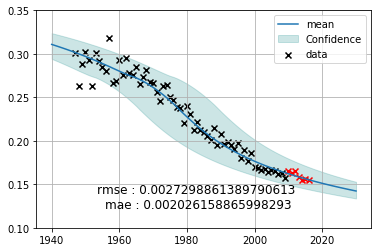

 20%|██        | 264/1296 [28:19<41:37,  2.42s/it]

0.0027298861389790613 0.002026158865998293
(('sa', 2), ('sa', 2), ('sal', 1), ('sa', 1))


 20%|██        | 265/1296 [28:20<34:50,  2.03s/it]

params:[-1.03507454e-01  2.05011464e+02]
0.006001748859354545 0.005460002440541044
(('sa', 2), ('sa', 2), ('sal', 1), ('sa', 2))


 21%|██        | 266/1296 [28:21<29:50,  1.74s/it]

params:[-1.03507590e-01  2.05011737e+02]
0.0060017569409087385 0.005460011575033278
(('sa', 2), ('sa', 2), ('sal', 1), ('sal', 1))


 21%|██        | 267/1296 [28:22<28:07,  1.64s/it]

params:[-9.69722315e-02  1.91998381e+02]
0.004705517653465204 0.0037648143308735837
(('sa', 2), ('sa', 2), ('sal', 1), ('sal', 2))


 21%|██        | 268/1296 [28:47<2:23:47,  8.39s/it]

params:[-9.85880425e-02  1.95311659e+02]
0.004093865366881451 0.003007404431254686
(('sa', 2), ('sa', 2), ('sal', 1), ('box_cox', 1))


 21%|██        | 269/1296 [28:48<1:49:26,  6.39s/it]

params:[-1.01569178e-01  2.00262482e+02]
0.004739987796468368 0.0037830190644969263
(('sa', 2), ('sa', 2), ('sal', 1), ('box_cox', 2))


 21%|██        | 270/1296 [28:50<1:23:09,  4.86s/it]

params:[-1.02758338e-01  2.01585765e+02]
0.004704956429876228 0.0037697294563907064
(('sa', 2), ('sa', 2), ('sal', 2), ('sa', 1))


 21%|██        | 271/1296 [28:58<1:40:09,  5.86s/it]

params:[-1.36775558e-01  2.69905272e+02]
0.021955640085966337 0.02173159430615083
(('sa', 2), ('sa', 2), ('sal', 2), ('sa', 2))


 21%|██        | 272/1296 [29:07<1:59:00,  6.97s/it]

params:[-1.00248731e-01  1.98625736e+02]
0.003639333184550191 0.0026976447427362327
(('sa', 2), ('sa', 2), ('sal', 2), ('sal', 1))


 21%|██        | 273/1296 [29:13<1:53:18,  6.65s/it]

params:[-9.89929664e-02  1.96038857e+02]
0.004491662551146405 0.0035189528191439034
(('sa', 2), ('sa', 2), ('sal', 2), ('sal', 2))


 21%|██        | 274/1296 [29:44<3:58:46, 14.02s/it]

params:[-9.94340886e-02  1.97030579e+02]
0.004053144333459167 0.002982173021798163
(('sa', 2), ('sa', 2), ('sal', 2), ('box_cox', 1))


 21%|██        | 275/1296 [29:48<3:02:38, 10.73s/it]

params:[-1.00025723e-01  1.97618173e+02]
0.0042475775132858095 0.0032121040891849545
(('sa', 2), ('sa', 2), ('sal', 2), ('box_cox', 2))


 21%|██▏       | 276/1296 [29:58<2:59:04, 10.53s/it]

params:[-4.64731648e-01  9.11724219e+02]
0.5630942368142794 0.5365185146113843
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sa', 1))
params:[-8.0071500e-02  1.5747089e+02]


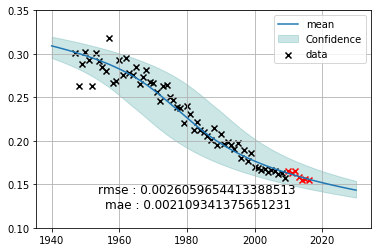

 21%|██▏       | 277/1296 [29:59<2:10:35,  7.69s/it]

0.0026059654413388513 0.002109341375651231
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sa', 2))
params:[-8.00715221e-02  1.57470937e+02]


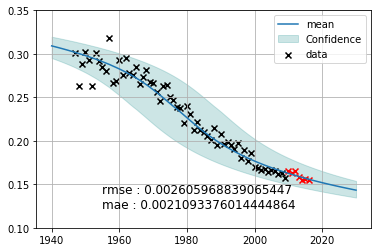

 21%|██▏       | 278/1296 [30:00<1:36:34,  5.69s/it]

0.002605968839065447 0.0021093376014444864
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sal', 1))


 22%|██▏       | 279/1296 [30:01<1:13:47,  4.35s/it]

params:[-1.07450814e-01  2.12844388e+02]
0.005775077529131885 0.00518737710969107
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sal', 2))
params:[-6.85201652e+01  1.36183748e+05]


 22%|██▏       | 280/1296 [30:12<1:47:31,  6.35s/it]

0.12874682889575975 0.1287334872692691
(('sa', 2), ('sa', 2), ('box_cox', 1), ('box_cox', 1))
params:[-8.54987180e-02  1.66714758e+02]


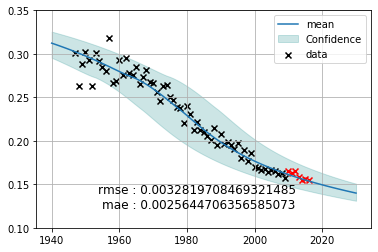

 22%|██▏       | 281/1296 [30:13<1:20:38,  4.77s/it]

0.0032819708469321485 0.0025644706356585073
(('sa', 2), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


 22%|██▏       | 282/1296 [30:14<1:02:16,  3.68s/it]

params:[-7.97334642e-02  1.54248163e+02]
0.004251005417223947 0.0035514972420353586
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sa', 1))
params:[-7.25100675e-02  1.41794537e+02]


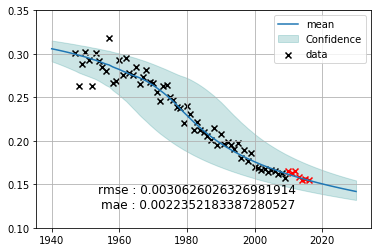

 22%|██▏       | 283/1296 [30:15<48:45,  2.89s/it]  

0.0030626026326981914 0.0022352183387280527
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sa', 2))
params:[-7.25098406e-02  1.41794093e+02]


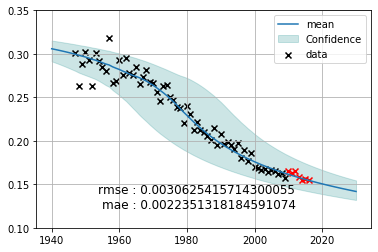

 22%|██▏       | 284/1296 [30:16<40:14,  2.39s/it]

0.0030625415714300055 0.0022351318184591074
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sal', 1))


 22%|██▏       | 285/1296 [30:18<37:06,  2.20s/it]

params:[-1.00630544e-01  1.99424403e+02]
0.003947383663501025 0.002919740991895653
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sal', 2))


 22%|██▏       | 286/1296 [30:30<1:25:43,  5.09s/it]

params:[-1.00384734e-01  1.98917927e+02]
0.0037816014670836126 0.0029212782325085396
(('sa', 2), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


 22%|██▏       | 287/1296 [30:31<1:04:21,  3.83s/it]

params:[-7.86417172e-02  1.52101487e+02]
0.003739880142790349 0.0030116604704122202
(('sa', 2), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


 22%|██▏       | 288/1296 [30:32<49:33,  2.95s/it]  

params:[-6.92292499e-02  1.32482776e+02]
0.004588025751956655 0.003940130616098487
(('sa', 2), ('sal', 1), ('sa', 1), ('sa', 1))


 22%|██▏       | 289/1296 [30:33<40:18,  2.40s/it]

params:[-1.03508026e-01  2.05012599e+02]
0.006001846515767072 0.005460120378936252
(('sa', 2), ('sal', 1), ('sa', 1), ('sa', 2))


 22%|██▏       | 290/1296 [30:35<38:18,  2.29s/it]

params:[-1.03508514e-01  2.05013569e+02]
0.006001934539439581 0.005460226294577332
(('sa', 2), ('sal', 1), ('sa', 1), ('sal', 1))


 22%|██▏       | 291/1296 [30:36<34:02,  2.03s/it]

params:[-9.69722626e-02  1.91998436e+02]
0.004705526326561345 0.0037648273731798903
(('sa', 2), ('sal', 1), ('sa', 1), ('sal', 2))


 23%|██▎       | 292/1296 [30:49<1:26:27,  5.17s/it]

params:[-9.42176382e-02  1.86422656e+02]
0.004370108678018482 0.0034082513450434315
(('sa', 2), ('sal', 1), ('sa', 1), ('box_cox', 1))


 23%|██▎       | 293/1296 [30:50<1:05:53,  3.94s/it]

params:[-1.02648081e-01  2.02398350e+02]
0.004881560604679451 0.003996277424378553
(('sa', 2), ('sal', 1), ('sa', 1), ('box_cox', 2))


 23%|██▎       | 294/1296 [30:51<52:21,  3.13s/it]  

params:[-1.03758575e-01  2.03570581e+02]
0.004831127447068715 0.003956368956170131
(('sa', 2), ('sal', 1), ('sa', 2), ('sa', 1))


 23%|██▎       | 295/1296 [30:53<44:25,  2.66s/it]

params:[-1.03509327e-01  2.05015157e+02]
0.006002112506231682 0.0054604426173577225
(('sa', 2), ('sal', 1), ('sa', 2), ('sa', 2))


 23%|██▎       | 296/1296 [30:54<39:38,  2.38s/it]

params:[-1.03508692e-01  2.05013923e+02]
0.006001939699237873 0.005460232236912039
(('sa', 2), ('sal', 1), ('sa', 2), ('sal', 1))


 23%|██▎       | 297/1296 [30:56<34:30,  2.07s/it]

params:[-9.69722291e-02  1.91998398e+02]
0.004705469398627706 0.0037647346181922787
(('sa', 2), ('sal', 1), ('sa', 2), ('sal', 2))


 23%|██▎       | 298/1296 [31:03<1:01:40,  3.71s/it]

params:[-9.59162493e-02  1.90278502e+02]
0.004182778123438917 0.003084725565388976
(('sa', 2), ('sal', 1), ('sa', 2), ('box_cox', 1))


 23%|██▎       | 299/1296 [31:04<47:55,  2.88s/it]  

params:[-1.02649330e-01  2.02400718e+02]
0.004883755091045323 0.003999402304169897
(('sa', 2), ('sal', 1), ('sa', 2), ('box_cox', 2))


 23%|██▎       | 300/1296 [31:05<39:13,  2.36s/it]

params:[-1.03750322e-01  2.03554177e+02]
0.004830946094114145 0.003956084779953691
(('sa', 2), ('sal', 1), ('sal', 1), ('sa', 1))


 23%|██▎       | 301/1296 [31:07<33:15,  2.01s/it]

params:[-9.68706269e-02  1.91796791e+02]
0.004709782865662221 0.00377092434853787
(('sa', 2), ('sal', 1), ('sal', 1), ('sa', 2))


 23%|██▎       | 302/1296 [31:08<29:56,  1.81s/it]

params:[-9.68708564e-02  1.91797283e+02]
0.0047096729389479175 0.0037707531683521217
(('sa', 2), ('sal', 1), ('sal', 1), ('sal', 1))


 23%|██▎       | 303/1296 [31:09<27:44,  1.68s/it]

params:[-9.76585534e-02  1.93360911e+02]
0.004847147871147181 0.003968596436585877
(('sa', 2), ('sal', 1), ('sal', 1), ('sal', 2))


 23%|██▎       | 304/1296 [31:18<1:02:22,  3.77s/it]

params:[-9.80045154e-02  1.94184762e+02]
0.0039858203102141505 0.003001123901644551
(('sa', 2), ('sal', 1), ('sal', 1), ('box_cox', 1))


 24%|██▎       | 305/1296 [31:19<49:33,  3.00s/it]  

params:[-9.56450812e-02  1.88454212e+02]
0.003958697581229922 0.0029062014321754237
(('sa', 2), ('sal', 1), ('sal', 1), ('box_cox', 2))


 24%|██▎       | 306/1296 [31:20<40:43,  2.47s/it]

params:[-9.70179227e-02  1.90118306e+02]
0.0038996400004940057 0.002889603416571494
(('sa', 2), ('sal', 1), ('sal', 2), ('sa', 1))


 24%|██▎       | 307/1296 [31:28<1:04:25,  3.91s/it]

params:[-9.59854329e-02  1.90011177e+02]
0.00473415514409888 0.0038410462443648724
(('sa', 2), ('sal', 1), ('sal', 2), ('sa', 2))


 24%|██▍       | 308/1296 [31:37<1:32:25,  5.61s/it]

params:[-9.75466831e-02  1.93269123e+02]
0.00406898473512752 0.0030610969067596883
(('sa', 2), ('sal', 1), ('sal', 2), ('sal', 1))


 24%|██▍       | 309/1296 [31:52<2:19:45,  8.50s/it]

params:[-9.66726678e-02  1.91364869e+02]
0.0048714663583462395 0.004050099756971424
(('sa', 2), ('sal', 1), ('sal', 2), ('sal', 2))


 24%|██▍       | 310/1296 [32:02<2:22:56,  8.70s/it]

params:[-9.80299620e-02  1.94238102e+02]
0.004020353711088439 0.003027214481382692
(('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1))


 24%|██▍       | 311/1296 [32:11<2:24:12,  8.78s/it]

params:[-9.08728898e-02  1.79286330e+02]
0.0038761736763618638 0.0029797204410734707
(('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 2))


 24%|██▍       | 312/1296 [32:23<2:42:11,  9.89s/it]

params:[-1.06126455e-01  2.08199555e+02]
0.004340109968728071 0.003503222797306927
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sa', 1))


 24%|██▍       | 313/1296 [32:24<1:58:17,  7.22s/it]

params:[-9.50425875e-02  1.87717867e+02]
0.004723727916437881 0.003945409765664745
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sa', 2))


 24%|██▍       | 314/1296 [32:25<1:27:42,  5.36s/it]

params:[-9.50442219e-02  1.87721135e+02]
0.004724106823834189 0.003945914441868628
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sal', 1))


 24%|██▍       | 315/1296 [32:26<1:07:00,  4.10s/it]

params:[-1.01450830e-01  2.00861623e+02]
0.005498621766184864 0.004838075383056314
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sal', 2))


 24%|██▍       | 316/1296 [32:49<2:40:18,  9.82s/it]

params:[-9.97463912e-02  1.97630587e+02]
0.004005061932124531 0.0029496142321166446
(('sa', 2), ('sal', 1), ('box_cox', 1), ('box_cox', 1))


 24%|██▍       | 317/1296 [32:50<1:56:26,  7.14s/it]

params:[-1.02405576e-01  2.00861278e+02]
0.005159280525164212 0.004393389743116245
(('sa', 2), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


 25%|██▍       | 318/1296 [32:51<1:25:36,  5.25s/it]

params:[-9.77593045e-02  1.90491319e+02]
0.0057856027790836664 0.0054064274656866
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sa', 1))


 25%|██▍       | 319/1296 [32:52<1:04:49,  3.98s/it]

params:[-8.73672844e-02  1.71892439e+02]
0.004286994366614003 0.0036581558447135176
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sa', 2))


 25%|██▍       | 320/1296 [32:53<50:00,  3.07s/it]  

params:[-8.73680606e-02  1.71893983e+02]
0.004287246414047684 0.0036584665590782195
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sal', 1))


 25%|██▍       | 321/1296 [32:55<41:39,  2.56s/it]

params:[-1.07937603e-01  2.13749098e+02]
0.006063662559357915 0.005545662546254001
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sal', 2))


 25%|██▍       | 322/1296 [33:01<59:33,  3.67s/it]

params:[-1.02704198e-01  2.03458143e+02]
0.003700195044184716 0.00275422964783033
(('sa', 2), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


 25%|██▍       | 323/1296 [33:02<47:09,  2.91s/it]

params:[-9.89549666e-02  1.92854941e+02]
0.006795022889614387 0.006485081343365403
(('sa', 2), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


 25%|██▌       | 324/1296 [33:03<37:55,  2.34s/it]

params:[-8.63770848e-02  1.66915352e+02]
0.009689500270592644 0.00949611857388533
(('sa', 2), ('sal', 2), ('sa', 1), ('sa', 1))


 25%|██▌       | 325/1296 [33:09<56:34,  3.50s/it]

params:[-1.03000922e-01  2.04001899e+02]
0.00514924247684593 0.004369051116015611
(('sa', 2), ('sal', 2), ('sa', 1), ('sa', 2))


 25%|██▌       | 326/1296 [33:19<1:25:14,  5.27s/it]

params:[-1.02658012e-01  2.03323504e+02]
0.0049302328145536724 0.0040747162837504415
(('sa', 2), ('sal', 2), ('sa', 1), ('sal', 1))


 25%|██▌       | 327/1296 [33:31<1:57:59,  7.31s/it]

params:[-1.02313790e-01  2.02691727e+02]
0.0038575043339270487 0.0028985263990676446
(('sa', 2), ('sal', 2), ('sa', 1), ('sal', 2))
params:[-5.1802760e+04  1.0319824e+08]


 25%|██▌       | 328/1296 [33:53<3:10:31, 11.81s/it]

0.008824115411189977 0.007825368519196954
(('sa', 2), ('sal', 2), ('sa', 1), ('box_cox', 1))


 25%|██▌       | 329/1296 [33:59<2:42:56, 10.11s/it]

params:[-1.02253722e-01  2.01599231e+02]
0.00441041494138678 0.0034271608984486257
(('sa', 2), ('sal', 2), ('sa', 1), ('box_cox', 2))


 25%|██▌       | 330/1296 [34:04<2:16:56,  8.51s/it]

params:[-1.02861805e-01  2.01786387e+02]
0.004406542090290794 0.003456526642643315
(('sa', 2), ('sal', 2), ('sa', 2), ('sa', 1))


 26%|██▌       | 331/1296 [34:21<2:59:37, 11.17s/it]

params:[-9.96621121e-02  1.97468797e+02]
0.003822671120546433 0.0027960283247114187
(('sa', 2), ('sal', 2), ('sa', 2), ('sa', 2))


 26%|██▌       | 332/1296 [34:43<3:52:52, 14.49s/it]

params:[-1.09223403e-01  2.15656527e+02]
0.00763769775444843 0.00734612470094432
(('sa', 2), ('sal', 2), ('sa', 2), ('sal', 1))


 26%|██▌       | 333/1296 [34:48<3:03:08, 11.41s/it]

params:[-9.90253829e-02  1.96103978e+02]
0.0044857836219298845 0.0035130806114177554
(('sa', 2), ('sal', 2), ('sa', 2), ('sal', 2))


 26%|██▌       | 334/1296 [35:09<3:49:43, 14.33s/it]

params:[-1.46157582e+01  2.92845095e+04]
0.36045092512433863 0.36040342155936506
(('sa', 2), ('sal', 2), ('sa', 2), ('box_cox', 1))


 26%|██▌       | 335/1296 [35:25<3:57:26, 14.82s/it]

params:[-9.74595978e-02  1.92254453e+02]
0.003676777800616607 0.0030643143424222458
(('sa', 2), ('sal', 2), ('sa', 2), ('box_cox', 2))


 26%|██▌       | 336/1296 [35:32<3:21:48, 12.61s/it]

params:[-1.05895254e-01  2.05738932e+02]
0.021358969751730912 0.021277302200387555
(('sa', 2), ('sal', 2), ('sal', 1), ('sa', 1))


 26%|██▌       | 337/1296 [35:49<3:42:18, 13.91s/it]

params:[-9.55667009e-02  1.89365405e+02]
0.0038494195717329754 0.003058001753954586
(('sa', 2), ('sal', 2), ('sal', 1), ('sa', 2))


 26%|██▌       | 338/1296 [36:16<4:41:52, 17.65s/it]

params:[-1.03653872e-01  2.05329906e+02]
0.0049172628828125994 0.004123457697128213
(('sa', 2), ('sal', 2), ('sal', 1), ('sal', 1))


 26%|██▌       | 339/1296 [36:20<3:38:22, 13.69s/it]

params:[-9.65020615e-02  1.90910247e+02]
0.004310024841152069 0.0033362373736184536
(('sa', 2), ('sal', 2), ('sal', 1), ('sal', 2))


 26%|██▌       | 340/1296 [36:43<4:23:49, 16.56s/it]

params:[-9.65458336e-02  1.91359649e+02]
0.00359846154574534 0.0029293543023141888
(('sa', 2), ('sal', 2), ('sal', 1), ('box_cox', 1))


 26%|██▋       | 341/1296 [37:02<4:34:07, 17.22s/it]

params:[-9.92598261e-02  1.95328930e+02]
0.006688494739030552 0.0063306452536673686
(('sa', 2), ('sal', 2), ('sal', 1), ('box_cox', 2))


 26%|██▋       | 342/1296 [37:18<4:30:05, 16.99s/it]

params:[ 2.13307396e-02 -3.81335664e+01]
0.08933161745535223 0.08658710278982354
(('sa', 2), ('sal', 2), ('sal', 2), ('sa', 1))


 26%|██▋       | 343/1296 [37:58<6:17:57, 23.80s/it]

params:[-1.00140212e-01  1.98424910e+02]
0.003724632520308609 0.0028751753058805585
(('sa', 2), ('sal', 2), ('sal', 2), ('sa', 2))


 27%|██▋       | 344/1296 [38:17<5:53:18, 22.27s/it]

params:[-1.64096317e-01  3.24068308e+02]
0.366924189304957 0.3478273100542835
(('sa', 2), ('sal', 2), ('sal', 2), ('sal', 1))


 27%|██▋       | 345/1296 [39:04<7:49:09, 29.60s/it]

params:[-9.87411759e-02  1.95650200e+02]
0.003646817719656642 0.0028986296514707244
(('sa', 2), ('sal', 2), ('sal', 2), ('sal', 2))
params:[-9.55744163e-02  1.89390748e+02]


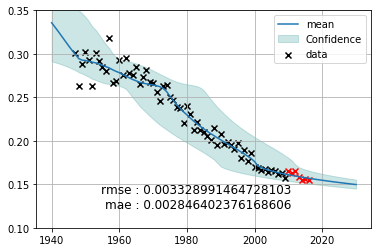

 27%|██▋       | 346/1296 [39:38<8:10:59, 31.01s/it]

0.003328991464728103 0.002846402376168606
(('sa', 2), ('sal', 2), ('sal', 2), ('box_cox', 1))


 27%|██▋       | 347/1296 [39:56<7:09:39, 27.17s/it]

params:[ 1.26784248e-02 -2.15713275e+01]
0.030610076582374655 0.02946111608479534
(('sa', 2), ('sal', 2), ('sal', 2), ('box_cox', 2))


 27%|██▋       | 348/1296 [40:08<5:55:22, 22.49s/it]

params:[-3.26537899e-02  6.92004376e+01]
0.015026569383328336 0.01481322089000811
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sa', 1))


 27%|██▋       | 349/1296 [40:26<5:35:21, 21.25s/it]

params:[-9.26431767e-02  1.83108703e+02]
0.0037791001562704624 0.002930275261375915
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sa', 2))
params:[-9.90525817e-02  1.95772104e+02]


 27%|██▋       | 350/1296 [40:34<4:34:34, 17.42s/it]

0.0034431579995159874 0.0026191141186921413
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sal', 1))


 27%|██▋       | 351/1296 [40:49<4:19:38, 16.49s/it]

params:[-3.30176702e-02  6.24784786e+01]
0.008017591638605524 0.0077449279335028865
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sal', 2))
params:[-4.09887526e+04  8.05832772e+07]


 27%|██▋       | 352/1296 [40:59<3:48:29, 14.52s/it]

0.007502476931867293 0.006594756704360307
(('sa', 2), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 27%|██▋       | 353/1296 [41:10<3:34:26, 13.64s/it]

params:[-1.02076156e-01  2.00204320e+02]
0.004692955316140059 0.0037614514110162083
(('sa', 2), ('sal', 2), ('box_cox', 1), ('box_cox', 2))


 27%|██▋       | 354/1296 [41:17<2:59:46, 11.45s/it]

params:[-2.12713478e-02  4.53850521e+01]
0.020011737658172345 0.01987934003618836
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sa', 1))


 27%|██▋       | 355/1296 [41:28<2:58:18, 11.37s/it]

params:[-8.87457532e-02  1.74635888e+02]
0.0044518246400831124 0.00381016814572139
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sa', 2))


 27%|██▋       | 356/1296 [41:38<2:53:25, 11.07s/it]

params:[-9.15876749e-02  1.80439837e+02]
0.004004143260390601 0.0031932621130311106
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sal', 1))


 28%|██▊       | 357/1296 [41:45<2:34:36,  9.88s/it]

params:[-1.02693868e-01  2.03393965e+02]
0.004602969179438698 0.003657781791066461
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sal', 2))
params:[ 3.04150885e+06 -5.90916409e+09]


 28%|██▊       | 358/1296 [41:52<2:19:00,  8.89s/it]

0.07890324115707484 0.07834422983647846
(('sa', 2), ('sal', 2), ('box_cox', 2), ('box_cox', 1))
params:[-1.00264575e-01  1.95787272e+02]


 28%|██▊       | 359/1296 [42:06<2:44:46, 10.55s/it]

0.0038064595303333643 0.0030348533561729086
(('sa', 2), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 28%|██▊       | 360/1296 [42:28<3:35:52, 13.84s/it]

params:[-8.55522023e-02  1.65370609e+02]
0.006462063594583487 0.00566072311966049
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sa', 1))
params:[-8.00714715e-02  1.57470837e+02]


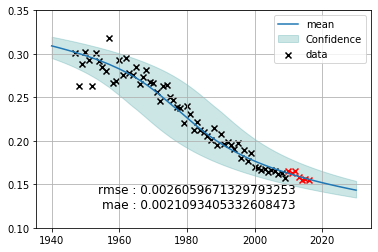

 28%|██▊       | 361/1296 [42:29<2:35:02,  9.95s/it]

0.0026059671329793253 0.0021093405332608473
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sa', 2))
params:[-8.00714709e-02  1.57470834e+02]


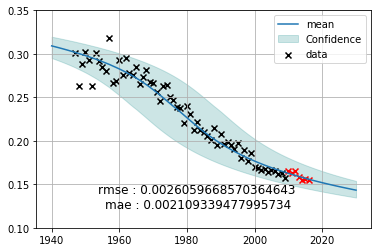

 28%|██▊       | 362/1296 [42:30<1:52:48,  7.25s/it]

0.0026059668570364643 0.002109339477995734
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sal', 1))


 28%|██▊       | 363/1296 [42:31<1:23:57,  5.40s/it]

params:[-1.07452525e-01  2.12847890e+02]
0.005774835979567866 0.005187064216428529
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sal', 2))


 28%|██▊       | 364/1296 [42:42<1:51:26,  7.17s/it]

params:[-1.02040137e-01  2.02258800e+02]
0.0036833142444077905 0.0027810885426643012
(('sa', 2), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 28%|██▊       | 365/1296 [42:43<1:20:43,  5.20s/it]

params:[-8.15964912e-02  1.59352348e+02]
0.003933047892548692 0.003198432696506409
(('sa', 2), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 28%|██▊       | 366/1296 [42:44<1:01:44,  3.98s/it]

params:[-7.83337738e-02  1.51873459e+02]
0.0043382466967175 0.0036352029557888015
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sa', 1))
params:[-8.00715139e-02  1.57470919e+02]


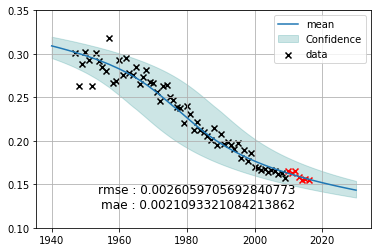

 28%|██▊       | 367/1296 [42:45<48:07,  3.11s/it]  

0.0026059705692840773 0.0021093321084213862
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sa', 2))
params:[-8.00712544e-02  1.57470404e+02]


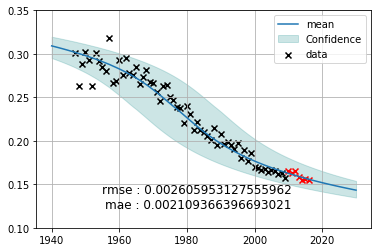

 28%|██▊       | 368/1296 [42:46<39:42,  2.57s/it]

0.002605953127555962 0.002109366396693021
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sal', 1))


 28%|██▊       | 369/1296 [42:47<33:43,  2.18s/it]

params:[-1.07445739e-01  2.12834098e+02]
0.005775015532240861 0.005187321991157702
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sal', 2))


 29%|██▊       | 370/1296 [43:08<1:57:04,  7.59s/it]

params:[-1.02448686e-01  2.03067293e+02]
0.0035996678847122518 0.0027435560991513736
(('sa', 2), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 29%|██▊       | 371/1296 [43:09<1:26:10,  5.59s/it]

params:[-8.15963519e-02  1.59352073e+02]
0.003932984061503688 0.0031983741464711645
(('sa', 2), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 29%|██▊       | 372/1296 [43:09<1:03:39,  4.13s/it]

params:[-7.83343328e-02  1.51874572e+02]
0.00433851669552794 0.0036355407893483133
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sa', 1))


 29%|██▉       | 373/1296 [43:11<51:23,  3.34s/it]  

params:[-1.08939591e-01  2.15795799e+02]
0.0057147680298615024 0.005113951068508311
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sa', 2))


 29%|██▉       | 374/1296 [43:12<42:32,  2.77s/it]

params:[-1.08933693e-01  2.15784089e+02]
0.005713971907834517 0.0051129611135480825
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sal', 1))


 29%|██▉       | 375/1296 [43:14<35:58,  2.34s/it]

params:[-9.92510584e-02  1.96596661e+02]
0.003997245705104726 0.0029879001948661587
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sal', 2))


 29%|██▉       | 376/1296 [43:24<1:14:54,  4.89s/it]

params:[-9.60487557e-02  1.90417274e+02]
0.003758288307348559 0.0029737406755004398
(('sa', 2), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 29%|██▉       | 377/1296 [43:26<58:24,  3.81s/it]  

params:[-1.07235579e-01  2.11577777e+02]
0.004116191106655809 0.0031325602708045957
(('sa', 2), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 29%|██▉       | 378/1296 [43:27<45:38,  2.98s/it]

params:[-1.08429292e-01  2.12916678e+02]
0.004254934283245303 0.0033228323553697553
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sa', 1))


 29%|██▉       | 379/1296 [43:48<2:07:29,  8.34s/it]

params:[-1.00522452e-01  1.99177280e+02]
0.0036299716494140977 0.002760237945228755
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sa', 2))


 29%|██▉       | 380/1296 [44:13<3:25:12, 13.44s/it]

params:[-1.02127111e-01  2.02302320e+02]
0.0038846881491322745 0.002867575908333273
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sal', 1))


 29%|██▉       | 381/1296 [44:23<3:07:53, 12.32s/it]

params:[-1.01380155e-01  2.00865942e+02]
0.003880078823602109 0.0028409693450620094
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sal', 2))


 29%|██▉       | 382/1296 [44:44<3:50:58, 15.16s/it]

params:[-1.01436454e-01  2.00951617e+02]
0.004018490652301635 0.003102449811905209
(('sa', 2), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 30%|██▉       | 383/1296 [44:53<3:20:33, 13.18s/it]

params:[-9.91885489e-02  1.95625662e+02]
0.003411010821453082 0.002778946449731899
(('sa', 2), ('box_cox', 1), ('sal', 2), ('box_cox', 2))


 30%|██▉       | 384/1296 [45:01<2:58:08, 11.72s/it]

params:[-1.87915218e-02  4.14499164e+01]
0.07109150661897043 0.06932383553002723
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 30%|██▉       | 385/1296 [45:02<2:06:59,  8.36s/it]

params:[-7.44655824e-02  1.45664920e+02]
0.0036954688026568034 0.002965888064106014
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 30%|██▉       | 386/1296 [45:03<1:32:02,  6.07s/it]

params:[-7.44658850e-02  1.45665516e+02]
0.0036956499881325086 0.0029660659497581193
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sal', 1))


 30%|██▉       | 387/1296 [45:04<1:08:53,  4.55s/it]

params:[-1.03230547e-01  2.04542326e+02]
0.004427323243175779 0.0034771285286968163
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 30%|██▉       | 388/1296 [45:05<57:00,  3.77s/it]  

params:[-1.72639500e+06  3.39160429e+09]
0.006032767391215443 0.005104391917945816
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 30%|███       | 389/1296 [45:06<42:57,  2.84s/it]

params:[-8.00542546e-02  1.54858230e+02]
0.004722982530664681 0.004122358262133466
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))


 30%|███       | 390/1296 [45:07<32:23,  2.15s/it]

params:[-7.03674453e-02  1.34701165e+02]
0.005742363164686991 0.005287707234999118
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sa', 1))
params:[-6.77998633e-02  1.32143833e+02]


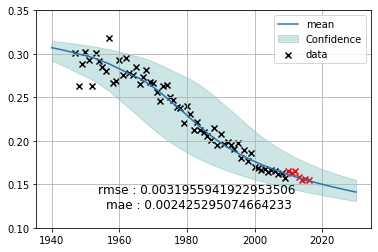

 30%|███       | 391/1296 [45:08<27:05,  1.80s/it]

0.0031955941922953506 0.002425295074664233
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sa', 2))
params:[-6.77997763e-02  1.32143669e+02]


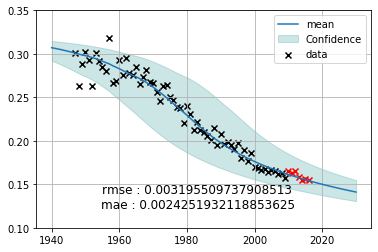

 30%|███       | 392/1296 [45:09<23:04,  1.53s/it]

0.003195509737908513 0.0024251932118853625
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 30%|███       | 393/1296 [45:11<27:14,  1.81s/it]

params:[-9.80873367e-02  1.94492987e+02]
0.0040773582637691225 0.0029978490950077724
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sal', 2))
params:[-4.56765187e+02  8.95767598e+05]


 30%|███       | 394/1296 [45:33<1:59:08,  7.92s/it]

0.00529343965584064 0.004602072696272834
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 30%|███       | 395/1296 [45:34<1:26:15,  5.74s/it]

params:[-6.95181568e-02  1.33020862e+02]
0.005599143141884213 0.005127401394497986
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 31%|███       | 396/1296 [45:35<1:03:04,  4.20s/it]

params:[-5.77662026e-02  1.08919544e+02]
0.006415574895021754 0.006027206006533967
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sa', 1))
params:[-7.25101598e-02  1.41794719e+02]


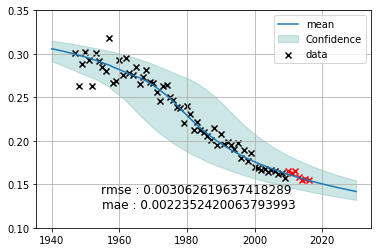

 31%|███       | 397/1296 [45:35<47:57,  3.20s/it]  

0.003062619637418289 0.0022352420063793993
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sa', 2))
params:[-7.25102874e-02  1.41794968e+02]


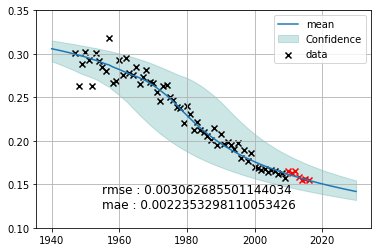

 31%|███       | 398/1296 [45:36<37:58,  2.54s/it]

0.003062685501144034 0.0022353298110053426
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sal', 1))


 31%|███       | 399/1296 [45:38<34:24,  2.30s/it]

params:[-1.00627021e-01  1.99417278e+02]
0.003947286193829663 0.0029196634529669546
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sal', 2))
params:[-1.62451561e+03  3.23709570e+06]


 31%|███       | 400/1296 [45:42<40:27,  2.71s/it]

0.021465880515147723 0.021184635681851083
(('sa', 2), ('box_cox', 2), ('sa', 1), ('box_cox', 1))
params:[-7.29509245e-02  1.41690241e+02]


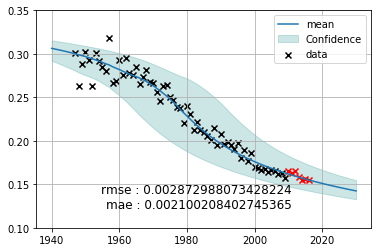

 31%|███       | 401/1296 [45:43<32:38,  2.19s/it]

0.002872988073428224 0.002100208402745365
(('sa', 2), ('box_cox', 2), ('sa', 1), ('box_cox', 2))
params:[-7.13469546e-02  1.37477457e+02]


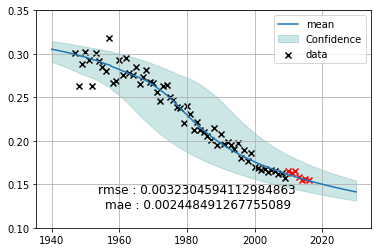

 31%|███       | 402/1296 [45:44<29:03,  1.95s/it]

0.0032304594112984863 0.002448491267755089
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sa', 1))
params:[-7.25100028e-02  1.41794414e+02]


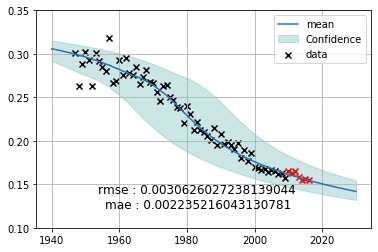

 31%|███       | 403/1296 [45:45<24:52,  1.67s/it]

0.0030626027238139044 0.002235216043130781
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sa', 2))
params:[-7.25095904e-02  1.41793601e+02]


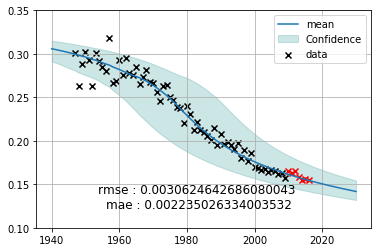

 31%|███       | 404/1296 [45:46<22:29,  1.51s/it]

0.0030624642686080043 0.002235026334003532
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sal', 1))


 31%|███▏      | 405/1296 [45:47<20:42,  1.40s/it]

params:[-1.00627404e-01  1.99418011e+02]
0.00394731524390505 0.0029197202525428068
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sal', 2))


 31%|███▏      | 406/1296 [45:55<46:42,  3.15s/it]

params:[-1.00734523e-01  1.99586211e+02]
0.003840383976968573 0.0029271523284117745
(('sa', 2), ('box_cox', 2), ('sa', 2), ('box_cox', 1))


 31%|███▏      | 407/1296 [45:56<37:36,  2.54s/it]

params:[-8.63200270e-02  1.70019357e+02]
0.0035702439810707033 0.003005289718369366
(('sa', 2), ('box_cox', 2), ('sa', 2), ('box_cox', 2))
params:[-7.13473130e-02  1.37478158e+02]


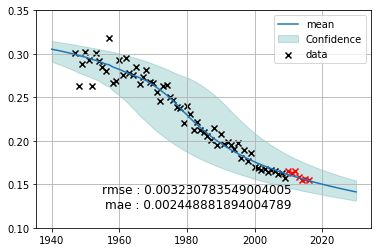

 31%|███▏      | 408/1296 [45:57<31:13,  2.11s/it]

0.003230783549004005 0.002448881894004789
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sa', 1))


 32%|███▏      | 409/1296 [45:58<26:18,  1.78s/it]

params:[-1.00864534e-01  1.99916487e+02]
0.00394375333273979 0.00293403995403221
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sa', 2))


 32%|███▏      | 410/1296 [45:59<23:39,  1.60s/it]

params:[-1.00865131e-01  1.99917645e+02]
0.003943791785146684 0.0029341027637303585
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sal', 1))


 32%|███▏      | 411/1296 [46:00<21:41,  1.47s/it]

params:[-1.00367350e-01  1.98804638e+02]
0.0038445272175914457 0.0028655388213225186
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sal', 2))
params:[-1.21445077e+11  2.41922100e+14]


 32%|███▏      | 412/1296 [46:08<50:00,  3.39s/it]

0.009213862624083058 0.008210635903788985
(('sa', 2), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 32%|███▏      | 413/1296 [46:09<39:00,  2.65s/it]

params:[-9.98250126e-02  1.96917637e+02]
0.003492621139769706 0.00283636333427489
(('sa', 2), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 32%|███▏      | 414/1296 [46:10<32:08,  2.19s/it]

params:[-1.00998167e-01  1.98208118e+02]
0.0034504020429713816 0.002725311094580986
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sa', 1))


 32%|███▏      | 415/1296 [46:16<48:02,  3.27s/it]

params:[-1.00921761e-01  1.99945395e+02]
0.0038100820641225894 0.0029115425689368274
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sa', 2))


 32%|███▏      | 416/1296 [46:28<1:28:10,  6.01s/it]

params:[-1.01276897e-01  2.00781272e+02]
0.003950524164039278 0.0029280733890439154
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sal', 1))


 32%|███▏      | 417/1296 [46:34<1:28:28,  6.04s/it]

params:[-9.99081718e-02  1.97983395e+02]
0.0037387271678133672 0.0029249218075327005
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sal', 2))
params:[-9.94796234e-02  1.97113875e+02]


 32%|███▏      | 418/1296 [46:57<2:42:50, 11.13s/it]

0.003755421111696375 0.0029392324156787314
(('sa', 2), ('box_cox', 2), ('sal', 2), ('box_cox', 1))
params:[-9.99993516e-02  1.97248112e+02]


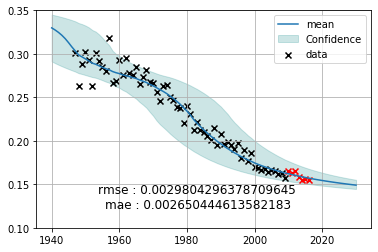

 32%|███▏      | 419/1296 [47:05<2:26:01,  9.99s/it]

0.0029804296378709645 0.002650444613582183
(('sa', 2), ('box_cox', 2), ('sal', 2), ('box_cox', 2))
params:[-1.00579851e-01  1.97396126e+02]


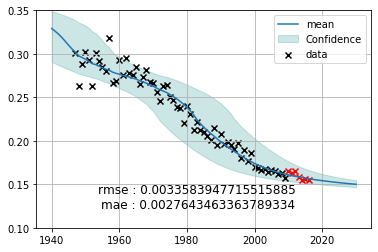

 32%|███▏      | 420/1296 [47:11<2:08:34,  8.81s/it]

0.0033583947715515885 0.0027643463363789334
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sa', 1))
params:[-6.62983369e-02  1.29126772e+02]


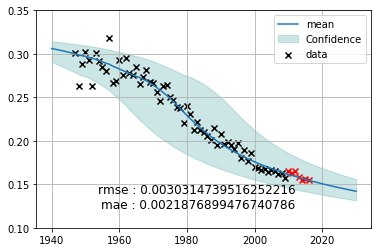

 32%|███▏      | 421/1296 [47:12<1:34:08,  6.46s/it]

0.0030314739516252216 0.0021876899476740786
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sa', 2))
params:[-6.62981172e-02  1.29126354e+02]


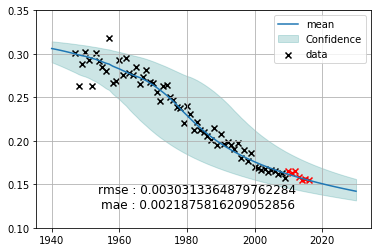

 33%|███▎      | 422/1296 [47:14<1:13:15,  5.03s/it]

0.0030313364879762284 0.0021875816209052856
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sal', 1))


 33%|███▎      | 423/1296 [47:15<56:01,  3.85s/it]  

params:[-9.60467245e-02  1.90478637e+02]
0.003842136623006948 0.002995500305385479
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sal', 2))


 33%|███▎      | 424/1296 [47:22<1:12:38,  5.00s/it]

params:[-1.02497975e-01  2.03517095e+02]
0.0037047395488748274 0.0029040092518243204
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('box_cox', 1))


 33%|███▎      | 425/1296 [47:24<57:52,  3.99s/it]  

params:[-6.87322379e-02  1.31477878e+02]
0.004948755497986953 0.00436603141573894
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('box_cox', 2))


 33%|███▎      | 426/1296 [47:25<43:25,  2.99s/it]

params:[-5.71357956e-02  1.07682028e+02]
0.005710942590815134 0.005237214522381378
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sa', 1))
params:[-6.37625179e-02  1.24123201e+02]


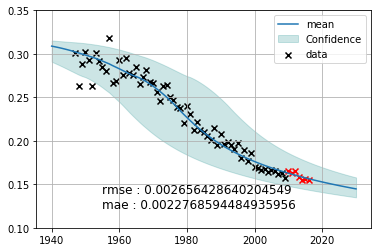

 33%|███▎      | 427/1296 [47:26<36:55,  2.55s/it]

0.002656428640204549 0.0022768594484935956
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sa', 2))
params:[-6.37624479e-02  1.24123056e+02]


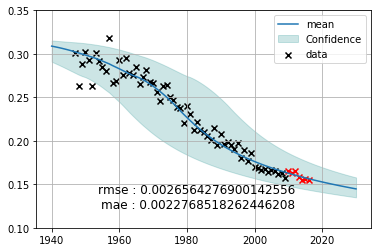

 33%|███▎      | 428/1296 [47:27<30:19,  2.10s/it]

0.0026564276900142556 0.0022768518262446208
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sal', 1))


 33%|███▎      | 429/1296 [47:28<26:50,  1.86s/it]

params:[-9.31907576e-02  1.84882320e+02]
0.0038962457625947348 0.0030801827446340596
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sal', 2))
params:[-1.10067687e+01  2.20375166e+04]


 33%|███▎      | 430/1296 [47:39<1:05:16,  4.52s/it]

0.5277864602968065 0.5277830549210158
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('box_cox', 1))


 33%|███▎      | 431/1296 [47:40<48:27,  3.36s/it]  

params:[-5.54694587e-02  1.04382725e+02]
0.005783114329454437 0.005318708126620065
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('box_cox', 2))


 33%|███▎      | 432/1296 [47:41<37:56,  2.63s/it]

params:[-4.41963700e-02  8.13997446e+01]
0.006439122242825691 0.006041140012095143
(('sal', 1), ('sa', 1), ('sa', 1), ('sa', 1))


 33%|███▎      | 433/1296 [47:42<31:08,  2.16s/it]

params:[-1.03506860e-01  2.05010545e+02]
0.0060011773714092245 0.0054592902195563986
(('sal', 1), ('sa', 1), ('sa', 1), ('sa', 2))


 33%|███▎      | 434/1296 [47:47<42:40,  2.97s/it]

params:[-1.11784803e-01  2.20894833e+02]
0.011470616267863073 0.011315660591667427
(('sal', 1), ('sa', 1), ('sa', 1), ('sal', 1))


 34%|███▎      | 435/1296 [47:49<41:14,  2.87s/it]

params:[-9.69729272e-02  1.91999706e+02]
0.004705573591280107 0.0037649167820896384
(('sal', 1), ('sa', 1), ('sa', 1), ('sal', 2))


 34%|███▎      | 436/1296 [47:57<1:01:45,  4.31s/it]

params:[-9.61341479e-02  1.90486120e+02]
0.0038280796744944233 0.003016917848093809
(('sal', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))


 34%|███▎      | 437/1296 [47:58<48:34,  3.39s/it]  

params:[-1.02651024e-01  2.02404267e+02]
0.0048807010277366865 0.003995049676884997
(('sal', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))


 34%|███▍      | 438/1296 [48:00<41:14,  2.88s/it]

params:[-1.11512476e-01  2.18409247e+02]
0.010178832376751457 0.010007245245831353
(('sal', 1), ('sa', 1), ('sa', 2), ('sa', 1))


 34%|███▍      | 439/1296 [48:04<48:14,  3.38s/it]

params:[-1.03508015e-01  2.05012572e+02]
0.006001847012163311 0.005460121259737728
(('sal', 1), ('sa', 1), ('sa', 2), ('sa', 2))


 34%|███▍      | 440/1296 [48:09<53:05,  3.72s/it]

params:[-1.03510118e-01  2.05016815e+02]
0.006002080337136478 0.005460396413712205
(('sal', 1), ('sa', 1), ('sa', 2), ('sal', 1))


 34%|███▍      | 441/1296 [48:12<48:25,  3.40s/it]

params:[-9.96367371e-02  1.97160397e+02]
0.0063625130860825085 0.005924081851438957
(('sal', 1), ('sa', 1), ('sa', 2), ('sal', 2))


 34%|███▍      | 442/1296 [48:44<2:51:45, 12.07s/it]

params:[-1.02409073e-01  2.02849293e+02]
0.004422618390695561 0.0034637813681240304
(('sal', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))


 34%|███▍      | 443/1296 [48:48<2:18:10,  9.72s/it]

params:[-1.13908058e-01  2.24793865e+02]
0.005920972072404222 0.005352086379933919
(('sal', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))


 34%|███▍      | 444/1296 [48:50<1:46:17,  7.49s/it]

params:[-1.11614361e-01  2.18610685e+02]
0.010088013822580968 0.009914623318139689
(('sal', 1), ('sa', 1), ('sal', 1), ('sa', 1))


 34%|███▍      | 445/1296 [48:53<1:23:45,  5.91s/it]

params:[-9.99364778e-02  1.97731947e+02]
0.006365168124060157 0.005924435280618792
(('sal', 1), ('sa', 1), ('sal', 1), ('sa', 2))


 34%|███▍      | 446/1296 [48:56<1:14:05,  5.23s/it]

params:[-9.68711471e-02  1.91797864e+02]
0.004709288634506043 0.003770192143186115
(('sal', 1), ('sa', 1), ('sal', 1), ('sal', 1))


 34%|███▍      | 447/1296 [48:58<57:50,  4.09s/it]  

params:[-9.76595703e-02  1.93362919e+02]
0.004847252366274589 0.003968750817219456
(('sal', 1), ('sa', 1), ('sal', 1), ('sal', 2))


 35%|███▍      | 448/1296 [49:02<57:12,  4.05s/it]

params:[-2.63526712e+00  5.21980933e+03]
0.008902136420116466 0.00867168690773158
(('sal', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))


 35%|███▍      | 449/1296 [49:03<46:25,  3.29s/it]

params:[-9.94226186e-02  1.95817681e+02]
0.005002256013423971 0.004263118175119278
(('sal', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))


 35%|███▍      | 450/1296 [49:10<1:00:06,  4.26s/it]

params:[-9.70185545e-02  1.90119540e+02]
0.003899482656131024 0.0028894405090361197
(('sal', 1), ('sa', 1), ('sal', 2), ('sa', 1))


 35%|███▍      | 451/1296 [49:36<2:32:57, 10.86s/it]

params:[-9.66235760e-02  1.91460664e+02]
0.003791207229084527 0.0029600236662829754
(('sal', 1), ('sa', 1), ('sal', 2), ('sa', 2))


 35%|███▍      | 452/1296 [49:46<2:27:51, 10.51s/it]

params:[-9.67710377e-02  1.91752784e+02]
0.0038018313030068838 0.0029569827200012105
(('sal', 1), ('sa', 1), ('sal', 2), ('sal', 1))


 35%|███▍      | 453/1296 [49:55<2:21:59, 10.11s/it]

params:[-9.91006456e-02  1.96288520e+02]
0.004136134045620937 0.0031293123416061713
(('sal', 1), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-9.83350249e-02  1.94822948e+02]


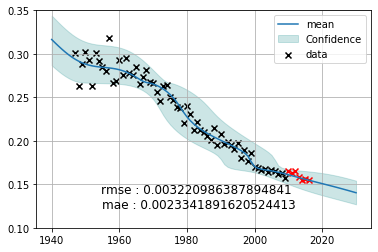

 35%|███▌      | 454/1296 [50:36<4:34:28, 19.56s/it]

0.003220986387894841 0.0023341891620524413
(('sal', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))


 35%|███▌      | 455/1296 [50:40<3:28:33, 14.88s/it]

params:[-1.40953522e-02  3.32638833e+01]
0.117164286560277 0.10371561767798625
(('sal', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))
params:[-9.42642026e-02  1.84822082e+02]


 35%|███▌      | 456/1296 [51:17<5:00:20, 21.45s/it]

0.0036662827122686276 0.003020333821454315
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))


 35%|███▌      | 457/1296 [51:19<3:38:31, 15.63s/it]

params:[-1.01325514e-01  1.99714066e+02]
0.01120090722000329 0.011036298435358213
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))


 35%|███▌      | 458/1296 [51:22<2:44:45, 11.80s/it]

params:[-9.59458907e-02  1.89503359e+02]
0.004964156020545208 0.004259961437674415
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))


 35%|███▌      | 459/1296 [51:24<2:01:54,  8.74s/it]

params:[-1.01279822e-01  2.00515521e+02]
0.005520707098144315 0.004868128756970006
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))


 35%|███▌      | 460/1296 [51:26<1:32:47,  6.66s/it]

params:[-7.20739293e-02  1.45667185e+02]
0.07420346698039262 0.07364582260439183
(('sal', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))


 36%|███▌      | 461/1296 [51:28<1:14:36,  5.36s/it]

params:[-1.03447448e-01  2.02924774e+02]
0.0053420549482227015 0.004636960195131189
(('sal', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


 36%|███▌      | 462/1296 [51:31<1:06:49,  4.81s/it]

params:[-1.03296560e-01  2.01044393e+02]
0.016812747589206416 0.016656069513194177
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))


 36%|███▌      | 463/1296 [51:34<56:43,  4.09s/it]  

params:[-9.30508991e-02  1.82878709e+02]
0.011352291340911749 0.011198278272696541
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))


 36%|███▌      | 464/1296 [51:36<49:46,  3.59s/it]

params:[-9.22501157e-02  1.81179895e+02]
0.013140023882007015 0.012995103664842756
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))


 36%|███▌      | 465/1296 [51:38<42:46,  3.09s/it]

params:[-1.12957767e-01  2.23601500e+02]
0.009527575386771266 0.009336033465292302
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))


 36%|███▌      | 466/1296 [51:52<1:27:42,  6.34s/it]

params:[-1.01322312e-01  2.00749785e+02]
0.0036946579069793628 0.0027496752899949955
(('sal', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))
params:[-1.00057245e-01  1.95065000e+02]


 36%|███▌      | 467/1296 [51:57<1:21:27,  5.90s/it]

0.006736912648325092 0.006424248460010377
(('sal', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


 36%|███▌      | 468/1296 [51:59<1:04:38,  4.68s/it]

params:[-8.81358751e-02  1.70028806e+02]
0.024039305095953752 0.023847439087193337
(('sal', 1), ('sa', 2), ('sa', 1), ('sa', 1))


 36%|███▌      | 469/1296 [52:01<54:40,  3.97s/it]  

params:[-1.11879054e-01  2.21100308e+02]
0.011295583571603257 0.011139615783773819
(('sal', 1), ('sa', 2), ('sa', 1), ('sa', 2))


 36%|███▋      | 470/1296 [52:03<46:50,  3.40s/it]

params:[-1.03504503e-01  2.05005573e+02]
0.006001343491054944 0.005459517340031179
(('sal', 1), ('sa', 2), ('sa', 1), ('sal', 1))


 36%|███▋      | 471/1296 [52:06<42:32,  3.09s/it]

params:[-9.98413937e-02  1.97560349e+02]
0.006489088600076874 0.006070547720816186
(('sal', 1), ('sa', 2), ('sa', 1), ('sal', 2))


 36%|███▋      | 472/1296 [52:25<1:50:08,  8.02s/it]

params:[-9.61600850e-02  1.90541062e+02]
0.0037965229671736924 0.0029983922264539076
(('sal', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))


 36%|███▋      | 473/1296 [52:27<1:25:18,  6.22s/it]

params:[-1.02647761e-01  2.02397887e+02]
0.004878388877254578 0.003991752283459806
(('sal', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))


 37%|███▋      | 474/1296 [52:29<1:07:10,  4.90s/it]

params:[-1.03756268e-01  2.03565995e+02]
0.004831161243591591 0.003956407070760388
(('sal', 1), ('sa', 2), ('sa', 2), ('sa', 1))


 37%|███▋      | 475/1296 [52:32<57:55,  4.23s/it]  

params:[-1.03512616e-01  2.05021765e+02]
0.00600252205602435 0.005460929250491547
(('sal', 1), ('sa', 2), ('sa', 2), ('sa', 2))


 37%|███▋      | 476/1296 [52:34<51:44,  3.79s/it]

params:[-1.11782962e-01  2.20890654e+02]
0.011469777293140946 0.0113148238077686
(('sal', 1), ('sa', 2), ('sa', 2), ('sal', 1))


 37%|███▋      | 477/1296 [52:37<46:06,  3.38s/it]

params:[-9.98161705e-02  1.97511122e+02]
0.006472098183653601 0.006050967560210464
(('sal', 1), ('sa', 2), ('sa', 2), ('sal', 2))


 37%|███▋      | 478/1296 [52:49<1:20:49,  5.93s/it]

params:[-9.69605387e-02  1.92124892e+02]
0.003802376055450602 0.0029690932802746628
(('sal', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))


 37%|███▋      | 479/1296 [52:51<1:07:11,  4.93s/it]

params:[-1.11690554e-01  2.19798281e+02]
0.008959376915786472 0.008751057900234754
(('sal', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))


 37%|███▋      | 480/1296 [52:55<1:00:26,  4.44s/it]

params:[-1.11486012e-01  2.18361658e+02]
0.010179269955090584 0.0100076736109104
(('sal', 1), ('sa', 2), ('sal', 1), ('sa', 1))


 37%|███▋      | 481/1296 [52:57<52:45,  3.88s/it]  

params:[-9.99985966e-02  1.97852893e+02]
0.006406525812469815 0.005972506671456034
(('sal', 1), ('sa', 2), ('sal', 1), ('sa', 2))


 37%|███▋      | 482/1296 [53:00<47:28,  3.50s/it]

params:[-9.68709165e-02  1.91797346e+02]
0.004709992995365074 0.0037712427140509613
(('sal', 1), ('sa', 2), ('sal', 1), ('sal', 1))


 37%|███▋      | 483/1296 [53:02<42:19,  3.12s/it]

params:[-9.76598405e-02  1.93363474e+02]
0.004847348481964592 0.003968877093247831
(('sal', 1), ('sa', 2), ('sal', 1), ('sal', 2))


 37%|███▋      | 484/1296 [53:19<1:38:31,  7.28s/it]

params:[-9.76955152e-02  1.93581698e+02]
0.003964352143285373 0.0030080563212619904
(('sal', 1), ('sa', 2), ('sal', 1), ('box_cox', 1))


 37%|███▋      | 485/1296 [53:24<1:30:36,  6.70s/it]

params:[-9.56446346e-02  1.88453330e+02]
0.003958708165595731 0.0029062097642891687
(('sal', 1), ('sa', 2), ('sal', 1), ('box_cox', 2))


 38%|███▊      | 486/1296 [53:28<1:18:56,  5.85s/it]

params:[-9.70181193e-02  1.90118674e+02]
0.0038994841502513 0.0028894101237780362
(('sal', 1), ('sa', 2), ('sal', 2), ('sa', 1))


 38%|███▊      | 487/1296 [53:39<1:40:43,  7.47s/it]

params:[-9.71317953e-02  1.92318774e+02]
0.004787536074787034 0.0038858032412680027
(('sal', 1), ('sa', 2), ('sal', 2), ('sa', 2))


 38%|███▊      | 488/1296 [53:52<2:01:55,  9.05s/it]

params:[-9.63604429e-02  1.90826841e+02]
0.0044953218496346335 0.003542951666598515
(('sal', 1), ('sa', 2), ('sal', 2), ('sal', 1))
params:[-1. -1.]


 38%|███▊      | 489/1296 [53:56<1:42:34,  7.63s/it]

0.09166641768607967 0.09155972875874488
(('sal', 1), ('sa', 2), ('sal', 2), ('sal', 2))


 38%|███▊      | 490/1296 [54:25<3:04:56, 13.77s/it]

params:[-1.01935636e-01  2.01969015e+02]
0.003985323548557515 0.003026953208356557
(('sal', 1), ('sa', 2), ('sal', 2), ('box_cox', 1))


 38%|███▊      | 491/1296 [54:50<3:51:01, 17.22s/it]

params:[-1.0851793e-01  2.1448061e+02]
0.003864849527276474 0.0029907158167223297
(('sal', 1), ('sa', 2), ('sal', 2), ('box_cox', 2))


 38%|███▊      | 492/1296 [55:01<3:24:58, 15.30s/it]

params:[-9.84980956e-02  1.93204530e+02]
0.003615994488246966 0.0028598278712882847
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sa', 1))


 38%|███▊      | 493/1296 [55:03<2:34:39, 11.56s/it]

params:[-9.59246081e-02  1.89461077e+02]
0.004959115801688058 0.00425349619494496
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sa', 2))


 38%|███▊      | 494/1296 [55:06<1:57:34,  8.80s/it]

params:[-1.00589683e-01  1.98393485e+02]
0.008246545401633259 0.008036129060646166
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sal', 1))


 38%|███▊      | 495/1296 [55:08<1:32:02,  6.89s/it]

params:[-1.01279805e-01  2.00515672e+02]
0.005518653682406124 0.004865484172710484
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sal', 2))


 38%|███▊      | 496/1296 [55:33<2:41:58, 12.15s/it]

params:[-1.00178667e-01  1.98484130e+02]
0.0038858234909571895 0.0028454941761571367
(('sal', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 1))


 38%|███▊      | 497/1296 [55:37<2:11:37,  9.88s/it]

params:[-1.11189262e-01  2.17755814e+02]
0.010832691646313604 0.010671556406890801
(('sal', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


 38%|███▊      | 498/1296 [55:39<1:37:20,  7.32s/it]

params:[-9.88807735e-02  1.92719456e+02]
0.006185571852906425 0.005842273649110837
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sa', 1))


 39%|███▊      | 499/1296 [55:40<1:15:21,  5.67s/it]

params:[-8.81489879e-02  1.73441899e+02]
0.004609310835861046 0.004047036938942253
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sa', 2))


 39%|███▊      | 500/1296 [55:45<1:10:12,  5.29s/it]

params:[-8.81625209e-02  1.73468889e+02]
0.004614287830144786 0.0040530974770884255
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sal', 1))


 39%|███▊      | 501/1296 [55:49<1:07:24,  5.09s/it]

params:[-1.13082033e-01  2.23844491e+02]
0.009622469327382626 0.009434088340225901
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sal', 2))


 39%|███▊      | 502/1296 [56:02<1:38:47,  7.47s/it]

params:[-1.01724476e-01  2.01505824e+02]
0.003757977299989649 0.0027598970897774666
(('sal', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


 39%|███▉      | 503/1296 [56:04<1:16:14,  5.77s/it]

params:[-1.03492187e-01  2.01353990e+02]
0.019404794524744057 0.019240745270871624
(('sal', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


 39%|███▉      | 504/1296 [56:06<1:00:37,  4.59s/it]

params:[-8.73444835e-02  1.68852845e+02]
0.009693388115335084 0.009500936952346075
(('sal', 1), ('sal', 1), ('sa', 1), ('sa', 1))


 39%|███▉      | 505/1296 [56:08<49:22,  3.75s/it]  

params:[-1.00566685e-01  1.98961992e+02]
0.006746271058783608 0.006362019442171078
(('sal', 1), ('sal', 1), ('sa', 1), ('sa', 2))


 39%|███▉      | 506/1296 [56:12<49:08,  3.73s/it]

params:[-9.97489071e-02  1.97366406e+02]
0.006247651940949915 0.005786983066929425
(('sal', 1), ('sal', 1), ('sa', 1), ('sal', 1))


 39%|███▉      | 507/1296 [56:14<43:11,  3.28s/it]

params:[-9.87126924e-02  1.95388980e+02]
0.006071480133208744 0.005573497650188711
(('sal', 1), ('sal', 1), ('sa', 1), ('sal', 2))


 39%|███▉      | 508/1296 [56:27<1:23:49,  6.38s/it]

params:[-9.78388519e-02  1.93866855e+02]
0.003974932838115173 0.003010134373052436
(('sal', 1), ('sal', 1), ('sa', 1), ('box_cox', 1))


 39%|███▉      | 509/1296 [56:30<1:09:43,  5.32s/it]

params:[-9.55227444e-02  1.88212584e+02]
0.00395482746541585 0.0029039436711562456
(('sal', 1), ('sal', 1), ('sa', 1), ('box_cox', 2))


 39%|███▉      | 510/1296 [56:34<1:04:47,  4.95s/it]

params:[-9.69083064e-02  1.89901330e+02]
0.003895456505532039 0.002883967265250559
(('sal', 1), ('sal', 1), ('sa', 2), ('sa', 1))


 39%|███▉      | 511/1296 [56:37<54:11,  4.14s/it]  

params:[-9.68703352e-02  1.91796323e+02]
0.004709421489430808 0.0037703722579469673
(('sal', 1), ('sal', 1), ('sa', 2), ('sa', 2))


 40%|███▉      | 512/1296 [56:39<47:49,  3.66s/it]

params:[-1.00083726e-01  1.98018900e+02]
0.006459421206775039 0.00603374820249618
(('sal', 1), ('sal', 1), ('sa', 2), ('sal', 1))


 40%|███▉      | 513/1296 [56:42<43:40,  3.35s/it]

params:[-9.76596624e-02  1.93363175e+02]
0.00484711584567289 0.003968540105983369
(('sal', 1), ('sal', 1), ('sa', 2), ('sal', 2))


 40%|███▉      | 514/1296 [56:59<1:38:29,  7.56s/it]

params:[-9.77377816e-02  1.93495062e+02]
0.0051327097158188175 0.004377747352669805
(('sal', 1), ('sal', 1), ('sa', 2), ('box_cox', 1))


 40%|███▉      | 515/1296 [57:03<1:23:16,  6.40s/it]

params:[-9.55241373e-02  1.88215354e+02]
0.003954788323842106 0.0029039106847210433
(('sal', 1), ('sal', 1), ('sa', 2), ('box_cox', 2))


 40%|███▉      | 516/1296 [57:06<1:10:06,  5.39s/it]

params:[-9.69088722e-02  1.89902506e+02]
0.0038954455480983328 0.002883927790432014
(('sal', 1), ('sal', 1), ('sal', 1), ('sa', 1))


 40%|███▉      | 517/1296 [57:09<59:25,  4.58s/it]  

params:[-9.76719545e-02  1.93387790e+02]
0.004846538917469789 0.003967847096493128
(('sal', 1), ('sal', 1), ('sal', 1), ('sa', 2))


 40%|███▉      | 518/1296 [57:11<52:40,  4.06s/it]

params:[-9.76714635e-02  1.93386827e+02]
0.004846815894949136 0.00396824451168087
(('sal', 1), ('sal', 1), ('sal', 1), ('sal', 1))


 40%|████      | 519/1296 [57:14<46:56,  3.63s/it]

params:[-9.82425950e-02  1.94467618e+02]
0.005875101915812686 0.005335756368706895
(('sal', 1), ('sal', 1), ('sal', 1), ('sal', 2))


 40%|████      | 520/1296 [57:41<2:16:25, 10.55s/it]

params:[-9.98263982e-02  1.97711267e+02]
0.004171115040723418 0.0031981787965007663
(('sal', 1), ('sal', 1), ('sal', 1), ('box_cox', 1))


 40%|████      | 521/1296 [57:47<2:01:34,  9.41s/it]

params:[-9.77431163e-02  1.92536659e+02]
0.00495359329552196 0.004153529360769122
(('sal', 1), ('sal', 1), ('sal', 1), ('box_cox', 2))


 40%|████      | 522/1296 [57:50<1:35:29,  7.40s/it]

params:[-9.76201609e-02  1.91323865e+02]
0.003960268223888626 0.0029604592297150433
(('sal', 1), ('sal', 1), ('sal', 2), ('sa', 1))


 40%|████      | 523/1296 [57:59<1:41:33,  7.88s/it]

params:[-8.90309025e-02  1.76786626e+02]
0.0040691827590643844 0.00307803039353632
(('sal', 1), ('sal', 1), ('sal', 2), ('sa', 2))


 40%|████      | 524/1296 [58:16<2:15:20, 10.52s/it]

params:[-9.89332969e-02  1.97842466e+02]
0.0094445086071244 0.007686095347280629
(('sal', 1), ('sal', 1), ('sal', 2), ('sal', 1))


 41%|████      | 525/1296 [58:28<2:20:19, 10.92s/it]

params:[-9.72210736e-02  1.92611593e+02]
0.0038824420779749015 0.002970292853069612
(('sal', 1), ('sal', 1), ('sal', 2), ('sal', 2))


 41%|████      | 526/1296 [58:51<3:08:10, 14.66s/it]

params:[-9.83066527e-02  1.94716729e+02]
0.004046080342204749 0.003008046802373432
(('sal', 1), ('sal', 1), ('sal', 2), ('box_cox', 1))


 41%|████      | 527/1296 [58:58<2:37:38, 12.30s/it]

params:[-9.87674503e-02  1.94593645e+02]
0.004708032959554354 0.003782037730662931
(('sal', 1), ('sal', 1), ('sal', 2), ('box_cox', 2))


 41%|████      | 528/1296 [59:02<2:05:38,  9.82s/it]

params:[-1.35530895e-02  3.21855864e+01]
0.01238351224340582 0.012162730396756416
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sa', 1))
params:[-8.88932306e-02  1.75429154e+02]


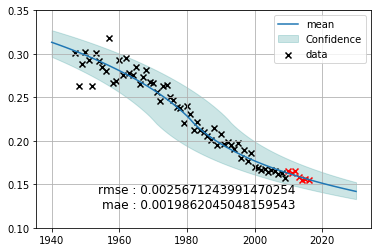

 41%|████      | 529/1296 [59:04<1:36:06,  7.52s/it]

0.0025671243991470254 0.0019862045048159543
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sa', 2))
params:[-9.03755945e-02  1.78240444e+02]


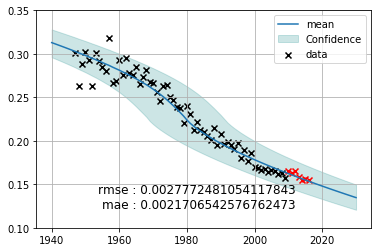

 41%|████      | 530/1296 [59:06<1:16:01,  5.95s/it]

0.0027772481054117843 0.0021706542576762473
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sal', 1))


 41%|████      | 531/1296 [59:08<59:54,  4.70s/it]  

params:[-1.03503648e-01  2.04973950e+02]
0.005451329105364316 0.004774245419258368
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sal', 2))


 41%|████      | 532/1296 [59:24<1:41:23,  7.96s/it]

params:[-1.01404112e-01  2.00973157e+02]
0.0037641526886002864 0.0027472904561624744
(('sal', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 1))


 41%|████      | 533/1296 [1:05:42<25:12:17, 118.92s/it]

params:[-3.40457869e-05  7.51359228e+00]
0.045173791429043035 0.04404749359475795
(('sal', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


 41%|████      | 534/1296 [1:05:45<17:50:18, 84.28s/it] 

params:[-9.30573828e-02  1.81049440e+02]
0.00537523765473303 0.004995594482166081
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sa', 1))


 41%|████▏     | 535/1296 [1:05:48<12:38:46, 59.82s/it]

params:[-8.37358964e-02  1.64426583e+02]
0.004516633486815063 0.004016147475542333
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sa', 2))


 41%|████▏     | 536/1296 [1:05:50<8:59:18, 42.58s/it] 

params:[-8.37426532e-02  1.64440408e+02]
0.004516296254610102 0.004015364328653447
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sal', 1))


 41%|████▏     | 537/1296 [1:05:54<6:30:21, 30.86s/it]

params:[-1.06521800e-01  2.10991516e+02]
0.005143865488668341 0.004415564563109792
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sal', 2))


 42%|████▏     | 538/1296 [1:06:06<5:18:54, 25.24s/it]

params:[-1.01571929e-01  2.01243113e+02]
0.0038994400515747715 0.0028679926643224163
(('sal', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


 42%|████▏     | 539/1296 [1:06:08<3:50:29, 18.27s/it]

params:[-9.25328192e-02  1.80045714e+02]
0.005123293336730608 0.004607787937760855
(('sal', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


 42%|████▏     | 540/1296 [1:06:10<2:50:00, 13.49s/it]

params:[-8.19923735e-02  1.58087998e+02]
0.00912580656295049 0.00893354323399689
(('sal', 1), ('sal', 2), ('sa', 1), ('sa', 1))


 42%|████▏     | 541/1296 [1:06:21<2:38:37, 12.61s/it]

params:[-9.63397124e-02  1.90890893e+02]
0.0037950222368526502 0.002969237576944252
(('sal', 1), ('sal', 2), ('sa', 1), ('sa', 2))


 42%|████▏     | 542/1296 [1:06:41<3:08:20, 14.99s/it]

params:[-1.08558586e-01  2.14924288e+02]
0.007320964426259754 0.006985796960804357
(('sal', 1), ('sal', 2), ('sa', 1), ('sal', 1))


 42%|████▏     | 543/1296 [1:06:54<3:01:21, 14.45s/it]

params:[-9.86161543e-02  1.95372995e+02]
0.003962259770288463 0.0029496318055839688
(('sal', 1), ('sal', 2), ('sa', 1), ('sal', 2))


 42%|████▏     | 544/1296 [1:07:10<3:04:13, 14.70s/it]

params:[-9.81872448e-02  1.94483582e+02]
0.00402337729928459 0.0029575529014492746
(('sal', 1), ('sal', 2), ('sa', 1), ('box_cox', 1))


 42%|████▏     | 545/1296 [1:07:20<2:46:19, 13.29s/it]

params:[-9.67996127e-02  1.90951189e+02]
0.0036088457959427274 0.003014612744187537
(('sal', 1), ('sal', 2), ('sa', 1), ('box_cox', 2))


 42%|████▏     | 546/1296 [1:08:02<4:35:41, 22.06s/it]

params:[-9.87713189e-02  1.93761073e+02]
0.0036194898563196133 0.0028482113135099773
(('sal', 1), ('sal', 2), ('sa', 2), ('sa', 1))


 42%|████▏     | 547/1296 [1:08:13<3:53:16, 18.69s/it]

params:[-9.33778233e-02  1.84927756e+02]
0.004211997555343332 0.0031912867333644284
(('sal', 1), ('sal', 2), ('sa', 2), ('sa', 2))


 42%|████▏     | 548/1296 [1:08:22<3:17:19, 15.83s/it]

params:[-9.73507937e-02  1.92745115e+02]
0.004800289263685013 0.003901806056900853
(('sal', 1), ('sal', 2), ('sa', 2), ('sal', 1))


 42%|████▏     | 549/1296 [1:08:31<2:50:57, 13.73s/it]

params:[-9.76306777e-02  1.93300208e+02]
0.004878652432884598 0.00401717963988981
(('sal', 1), ('sal', 2), ('sa', 2), ('sal', 2))


 42%|████▏     | 550/1296 [1:09:03<3:57:33, 19.11s/it]

params:[-9.82489643e-02  1.94621046e+02]
0.003979063953283429 0.002922053351516633
(('sal', 1), ('sal', 2), ('sa', 2), ('box_cox', 1))


 43%|████▎     | 551/1296 [1:09:27<4:18:25, 20.81s/it]

params:[-9.59084319e-02  1.88975280e+02]
0.003994657555375953 0.002926948713711008
(('sal', 1), ('sal', 2), ('sa', 2), ('box_cox', 2))


 43%|████▎     | 552/1296 [1:09:39<3:41:45, 17.88s/it]

params:[-9.86563700e-02  1.93577873e+02]
0.0037236085766601972 0.0030369937415492066
(('sal', 1), ('sal', 2), ('sal', 1), ('sa', 1))


 43%|████▎     | 553/1296 [1:09:53<3:29:01, 16.88s/it]

params:[-1.00315745e-01  1.98873587e+02]
0.003759306143234085 0.0029742344732607956
(('sal', 1), ('sal', 2), ('sal', 1), ('sa', 2))


 43%|████▎     | 554/1296 [1:10:01<2:55:17, 14.18s/it]

params:[-9.87829141e-02  1.95700335e+02]
0.0039619965422035535 0.002935792035234915
(('sal', 1), ('sal', 2), ('sal', 1), ('sal', 1))


 43%|████▎     | 555/1296 [1:10:16<2:57:47, 14.40s/it]

params:[-9.84309239e-02  1.95007348e+02]
0.003948227863151687 0.002951494634944009
(('sal', 1), ('sal', 2), ('sal', 1), ('sal', 2))
params:[ -655.01345783 -1684.78194451]


 43%|████▎     | 556/1296 [1:10:34<3:13:17, 15.67s/it]

0.043741327866808594 0.04351741880252559
(('sal', 1), ('sal', 2), ('sal', 1), ('box_cox', 1))


 43%|████▎     | 557/1296 [1:10:40<2:36:45, 12.73s/it]

params:[-9.65318347e-02  1.90199599e+02]
0.004205229475054429 0.0032200786113308066
(('sal', 1), ('sal', 2), ('sal', 1), ('box_cox', 2))


 43%|████▎     | 558/1296 [1:10:56<2:48:16, 13.68s/it]

params:[-9.67354269e-02  1.89554309e+02]
0.003921311483654432 0.0029166250381652153
(('sal', 1), ('sal', 2), ('sal', 2), ('sa', 1))


 43%|████▎     | 559/1296 [1:11:09<2:45:24, 13.47s/it]

params:[-9.80093474e-02  1.94149613e+02]
0.003997896961323915 0.00294025464405015
(('sal', 1), ('sal', 2), ('sal', 2), ('sa', 2))


 43%|████▎     | 560/1296 [1:11:23<2:45:12, 13.47s/it]

params:[-9.80903912e-02  1.94292296e+02]
0.004051521344080584 0.002972280968165688
(('sal', 1), ('sal', 2), ('sal', 2), ('sal', 1))
params:[-1. -1.]


 43%|████▎     | 561/1296 [1:11:36<2:42:59, 13.31s/it]

0.06938908292212063 0.06924807771000607
(('sal', 1), ('sal', 2), ('sal', 2), ('sal', 2))


 43%|████▎     | 562/1296 [1:12:14<4:13:22, 20.71s/it]

params:[-1.03333375e-01  2.04930494e+02]
0.00398222442250876 0.0029156915741336475
(('sal', 1), ('sal', 2), ('sal', 2), ('box_cox', 1))


 43%|████▎     | 563/1296 [1:12:45<4:52:03, 23.91s/it]

params:[-9.86783192e-02  1.94596973e+02]
0.003413979892709853 0.0028321276247906813
(('sal', 1), ('sal', 2), ('sal', 2), ('box_cox', 2))


 44%|████▎     | 564/1296 [1:12:59<4:13:52, 20.81s/it]

params:[-2.31216981e-01  4.52020486e+02]
0.17007862075890573 0.1592966896818049
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sa', 1))
params:[-8.90537955e-02  1.75717529e+02]


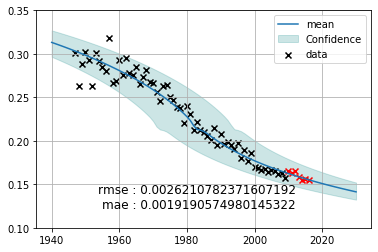

 44%|████▎     | 565/1296 [1:13:05<3:21:07, 16.51s/it]

0.0026210782371607192 0.0019190574980145322
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sa', 2))


 44%|████▎     | 566/1296 [1:13:21<3:17:51, 16.26s/it]

params:[ 2.43940386e-02 -4.69640379e+01]
0.024691877997498633 0.02152116298911403
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sal', 1))


 44%|████▍     | 567/1296 [1:13:31<2:55:41, 14.46s/it]

params:[-9.92013464e-02  1.96522043e+02]
0.0039579708180547775 0.002940296525975744
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sal', 2))


 44%|████▍     | 568/1296 [1:14:06<4:10:14, 20.62s/it]

params:[-9.93424551e-02  1.96847108e+02]
0.00387812572290212 0.00297527906564009
(('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 44%|████▍     | 569/1296 [1:14:16<3:32:18, 17.52s/it]

params:[-9.73181735e-02  1.90672501e+02]
0.004370858396926986 0.0034373701045412913
(('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2))


 44%|████▍     | 570/1296 [1:14:30<3:19:44, 16.51s/it]

params:[ 1.48673565e-02 -2.80590667e+01]
0.03782201387131761 0.03732264443193088
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sa', 1))


 44%|████▍     | 571/1296 [1:14:39<2:49:28, 14.03s/it]

params:[-8.25250459e-02  1.62127719e+02]
0.0036223691914896144 0.002913771210672731
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sa', 2))


 44%|████▍     | 572/1296 [1:14:52<2:46:22, 13.79s/it]

params:[-8.21890677e-02  1.61659279e+02]
0.003874912410697736 0.002877633031034677
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sal', 1))


 44%|████▍     | 573/1296 [1:15:00<2:24:08, 11.96s/it]

params:[-1.00808529e-01  1.99710140e+02]
0.003963125099704978 0.002907694085702001
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sal', 2))
params:[-1.38881931e+08  2.71874003e+11]


 44%|████▍     | 574/1296 [1:15:36<3:51:23, 19.23s/it]

0.003963746792137872 0.003711565917195058
(('sal', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 1))


 44%|████▍     | 575/1296 [1:15:47<3:21:31, 16.77s/it]

params:[-3.05470034e-01  6.01232580e+02]
0.5931473639547227 0.5520547637231166
(('sal', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 44%|████▍     | 576/1296 [1:16:28<4:50:07, 24.18s/it]

params:[-8.45650893e-02  1.63389943e+02]
0.006552149005404546 0.006031213520777829
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))


 45%|████▍     | 577/1296 [1:16:31<3:31:38, 17.66s/it]

params:[-9.96441242e-02  1.96412885e+02]
0.009295091878096623 0.009107842419488496
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sa', 2))


 45%|████▍     | 578/1296 [1:16:33<2:34:37, 12.92s/it]

params:[-9.97609470e-02  1.96624624e+02]
0.009722622054045739 0.009542247161096754
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sal', 1))


 45%|████▍     | 579/1296 [1:16:35<1:56:05,  9.72s/it]

params:[-1.06772891e-01  2.11326093e+02]
0.008268546252001924 0.008016566857187423
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sal', 2))
params:[-100.99999968 -101.00000037]


 45%|████▍     | 580/1296 [1:16:42<1:46:30,  8.93s/it]

0.08727494740610918 0.08716295617173124
(('sal', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 45%|████▍     | 581/1296 [1:16:45<1:27:01,  7.30s/it]

params:[-9.39994040e-02  1.84713102e+02]
0.0039991653120174985 0.0031040150363807117
(('sal', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 45%|████▍     | 582/1296 [1:16:48<1:09:39,  5.85s/it]

params:[-9.71955592e-02  1.89547229e+02]
0.009606787001240373 0.009425963948985252
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sa', 1))


 45%|████▍     | 583/1296 [1:16:50<56:43,  4.77s/it]  

params:[-9.98530561e-02  1.96804006e+02]
0.009846635484651017 0.009668043045814315
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sa', 2))


 45%|████▌     | 584/1296 [1:16:53<49:13,  4.15s/it]

params:[-9.96521409e-02  1.96424431e+02]
0.00937488740330072 0.009189017363663494
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sal', 1))


 45%|████▌     | 585/1296 [1:16:55<41:40,  3.52s/it]

params:[-1.06840128e-01  2.11461500e+02]
0.008268468426428555 0.008016406558822745
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sal', 2))


 45%|████▌     | 586/1296 [1:17:06<1:09:50,  5.90s/it]

params:[-9.97730912e-02  1.97683884e+02]
0.004016435914547761 0.002963287279379762
(('sal', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 45%|████▌     | 587/1296 [1:17:08<55:31,  4.70s/it]  

params:[-9.39375952e-02  1.84589782e+02]
0.00399324811896513 0.0030973732496233047
(('sal', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 45%|████▌     | 588/1296 [1:17:13<56:52,  4.82s/it]

params:[-9.33009243e-02  1.82238638e+02]
0.003464514264050569 0.0028009681329889758
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sa', 1))


 45%|████▌     | 589/1296 [1:17:15<47:22,  4.02s/it]

params:[-1.05394892e-01  2.08601362e+02]
0.0070040423422187996 0.006636286502461742
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sa', 2))


 46%|████▌     | 590/1296 [1:17:18<42:23,  3.60s/it]

params:[-1.07885665e-01  2.13518024e+02]
0.0079469138707977 0.007671128487903106
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sal', 1))


 46%|████▌     | 591/1296 [1:17:21<38:49,  3.30s/it]

params:[-9.88448764e-02  1.95666833e+02]
0.005337133562424253 0.004662137237510391
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sal', 2))


 46%|████▌     | 592/1296 [1:17:41<1:37:43,  8.33s/it]

params:[-9.87156867e-02  1.95611821e+02]
0.003965096834990033 0.0029584871394368766
(('sal', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 46%|████▌     | 593/1296 [1:17:48<1:35:16,  8.13s/it]

params:[-1.06492617e-01  2.09911750e+02]
0.005465770739410533 0.0048452607268265014
(('sal', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 46%|████▌     | 594/1296 [1:17:51<1:14:52,  6.40s/it]

params:[-1.07586564e-01  2.11046109e+02]
0.005648876196760003 0.005103246827409722
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sa', 1))


 46%|████▌     | 595/1296 [1:18:13<2:10:46, 11.19s/it]

params:[-1.00732394e-01  1.99574187e+02]
0.003926053882934005 0.002871995727673981
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sa', 2))


 46%|████▌     | 596/1296 [1:18:28<2:23:09, 12.27s/it]

params:[-1.00200712e-01  1.98559475e+02]
0.003709765943323882 0.0028015831961842835
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sal', 1))


 46%|████▌     | 597/1296 [1:18:31<1:50:08,  9.45s/it]

params:[-1.05680715e-01  2.09234393e+02]
0.0074769337834362905 0.007159004905827687
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sal', 2))
params:[-1. -1.]


 46%|████▌     | 598/1296 [1:18:56<2:45:12, 14.20s/it]

0.10687342579697746 0.10678192815736928
(('sal', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 46%|████▌     | 599/1296 [1:19:10<2:43:04, 14.04s/it]

params:[-9.95648134e-02  1.96374947e+02]
0.0035327403647528177 0.0028670286242204906
(('sal', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 2))


 46%|████▋     | 600/1296 [1:19:32<3:10:58, 16.46s/it]

params:[-1.03429206e-01  2.02943894e+02]
0.0036215539838419315 0.0026924369541201365
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 46%|████▋     | 601/1296 [1:19:33<2:18:51, 11.99s/it]

params:[-9.17910674e-02  1.80302381e+02]
0.01192689748975968 0.01177597192171376
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 46%|████▋     | 602/1296 [1:19:37<1:49:51,  9.50s/it]

params:[-9.16158527e-02  1.79924783e+02]
0.01245771083289268 0.012309212145004312
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 1))
params:[-1.12289679e-01  2.22293692e+02]


 47%|████▋     | 603/1296 [1:19:43<1:38:02,  8.49s/it]

0.009091325339493124 0.008882758092222229
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 47%|████▋     | 604/1296 [1:19:59<2:02:55, 10.66s/it]

params:[-1.03065763e-01  2.04075833e+02]
0.0037429871845189653 0.0028112366747577605
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 47%|████▋     | 605/1296 [1:20:02<1:34:51,  8.24s/it]

params:[-1.03738331e-01  2.02089375e+02]
0.01468993065963325 0.014545793804945497
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))


 47%|████▋     | 606/1296 [1:20:03<1:11:46,  6.24s/it]

params:[-8.52023038e-02  1.64561683e+02]
0.010258877557058413 0.01008336048587964
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 1))


 47%|████▋     | 607/1296 [1:20:05<55:54,  4.87s/it]  

params:[-8.23574600e-02  1.61017753e+02]
0.014930846346804924 0.014795098035500902
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 2))


 47%|████▋     | 608/1296 [1:20:07<48:00,  4.19s/it]

params:[-7.96019347e-02  1.55829521e+02]
0.006379829652139917 0.006025324571078219
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 47%|████▋     | 609/1296 [1:20:11<45:50,  4.00s/it]

params:[-1.07385795e-01  2.12696355e+02]
0.0054722375572425035 0.004854751802938452
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 2))
params:[-1.01306847e-01  2.00700936e+02]


 47%|████▋     | 610/1296 [1:20:22<1:10:50,  6.20s/it]

0.0036489799638543914 0.0027338261420555682
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 47%|████▋     | 611/1296 [1:20:27<1:07:17,  5.89s/it]

params:[-8.91231745e-02  1.72104089e+02]
0.02065134723732998 0.020497904598935846
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 47%|████▋     | 612/1296 [1:20:29<53:02,  4.65s/it]  

params:[-7.37372996e-02  1.40788463e+02]
0.02358122704957349 0.023411604969571616
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sa', 1))


 47%|████▋     | 613/1296 [1:20:31<43:39,  3.83s/it]

params:[-8.73677629e-02  1.71893357e+02]
0.0042873216776839074 0.003658550891880536
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sa', 2))


 47%|████▋     | 614/1296 [1:20:33<36:12,  3.18s/it]

params:[-8.73740213e-02  1.71905963e+02]
0.004288664392688838 0.0036602577876358295
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sal', 1))


 47%|████▋     | 615/1296 [1:20:35<33:43,  2.97s/it]

params:[-1.07937355e-01  2.13748628e+02]
0.0060636830985945946 0.005545676167238496
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sal', 2))


 48%|████▊     | 616/1296 [1:20:51<1:17:13,  6.81s/it]

params:[-1.00938585e-01  1.99989768e+02]
0.003904317718812704 0.0028548716292275756
(('sal', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 1))


 48%|████▊     | 617/1296 [1:20:53<1:00:19,  5.33s/it]

params:[-9.09868192e-02  1.77625483e+02]
0.014579662678874516 0.01444243379190001
(('sal', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 2))


 48%|████▊     | 618/1296 [1:20:55<47:58,  4.25s/it]  

params:[-8.84929785e-02  1.71719406e+02]
0.013041986768255838 0.012898799322776834
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sa', 1))


 48%|████▊     | 619/1296 [1:20:57<41:34,  3.68s/it]

params:[-8.73610797e-02  1.71880010e+02]
0.004285379491277437 0.003656131973367691
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sa', 2))


 48%|████▊     | 620/1296 [1:20:58<33:00,  2.93s/it]

params:[-8.73702504e-02  1.71898353e+02]
0.004287918662706981 0.003659301690616449
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sal', 1))


 48%|████▊     | 621/1296 [1:21:02<35:29,  3.15s/it]

params:[-1.07935681e-01  2.13745366e+02]
0.0060623357442979595 0.0055441189650289125
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sal', 2))


 48%|████▊     | 622/1296 [1:21:09<49:12,  4.38s/it]

params:[-1.01274275e-01  2.00664763e+02]
0.003770699925811252 0.0027724246667978664
(('sal', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 1))


 48%|████▊     | 623/1296 [1:21:12<44:23,  3.96s/it]

params:[-8.81034900e-02  1.72273169e+02]
0.006096532740853308 0.005716440347698205
(('sal', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 2))


 48%|████▊     | 624/1296 [1:21:14<37:59,  3.39s/it]

params:[-8.89468603e-02  1.72612954e+02]
0.013835697162814364 0.013696529905002098
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sa', 1))


 48%|████▊     | 625/1296 [1:21:17<34:26,  3.08s/it]

params:[-1.09353059e-01  2.16537346e+02]
0.005944415258487509 0.005400782316760991
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sa', 2))


 48%|████▊     | 626/1296 [1:21:20<34:47,  3.12s/it]

params:[-1.09352984e-01  2.16537189e+02]
0.005944207349752463 0.005400548807541463
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sal', 1))


 48%|████▊     | 627/1296 [1:21:22<31:32,  2.83s/it]

params:[-9.98242469e-02  1.97731628e+02]
0.004190188384867507 0.0032011435888283884
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sal', 2))


 48%|████▊     | 628/1296 [1:21:35<1:06:12,  5.95s/it]

params:[-1.08569905e-01  2.15070947e+02]
0.0060073462233995395 0.005440058458381093
(('sal', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 49%|████▊     | 629/1296 [1:21:37<52:07,  4.69s/it]  

params:[-1.07604668e-01  2.12236962e+02]
0.004440567112222727 0.0035063479544930015
(('sal', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 49%|████▊     | 630/1296 [1:21:38<40:59,  3.69s/it]

params:[-1.08233433e-01  2.12474359e+02]
0.004505766223996507 0.0035903036993261022
(('sal', 1), ('box_cox', 2), ('sal', 2), ('sa', 1))


 49%|████▊     | 631/1296 [1:21:49<1:05:12,  5.88s/it]

params:[-1.01267823e-01  2.00735807e+02]
0.003752701693915859 0.002807064293222135
(('sal', 1), ('box_cox', 2), ('sal', 2), ('sa', 2))
params:[-5.33101443e+02  1.06119559e+06]


 49%|████▉     | 632/1296 [1:22:01<1:23:12,  7.52s/it]

0.006115102545962663 0.0046965872344034475
(('sal', 1), ('box_cox', 2), ('sal', 2), ('sal', 1))


 49%|████▉     | 633/1296 [1:22:13<1:38:26,  8.91s/it]

params:[-1.08622322e-01  2.14974537e+02]
0.00797041302375104 0.007699222651364781
(('sal', 1), ('box_cox', 2), ('sal', 2), ('sal', 2))
params:[-2.09290040e+04  4.00927865e+07]


 49%|████▉     | 634/1296 [1:22:31<2:09:39, 11.75s/it]

0.02189258847359304 0.02172238555119186
(('sal', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 1))


 49%|████▉     | 635/1296 [1:22:44<2:12:01, 11.98s/it]

params:[-1.02264365e-01  2.01574194e+02]
0.0039138041983669035 0.0030064699227989483
(('sal', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 2))


 49%|████▉     | 636/1296 [1:23:08<2:51:25, 15.58s/it]

params:[-1.01260720e-01  1.98709715e+02]
0.003389729035883443 0.0027262958090563277
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 1))


 49%|████▉     | 637/1296 [1:23:11<2:09:23, 11.78s/it]

params:[-8.08254210e-02  1.58231533e+02]
0.007473125363609795 0.007183481135909743
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 2))


 49%|████▉     | 638/1296 [1:23:12<1:36:29,  8.80s/it]

params:[-8.30005213e-02  1.62279969e+02]
0.016019697433857262 0.015887465477020104
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 1))


 49%|████▉     | 639/1296 [1:23:16<1:18:27,  7.17s/it]

params:[-1.12456916e-01  2.22650007e+02]
0.008384309771343327 0.008145435293546444
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 2))


 49%|████▉     | 640/1296 [1:23:25<1:23:46,  7.66s/it]

params:[-1.01124439e-01  2.00330429e+02]
0.0037408150975154156 0.0027951202327144153
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 1))


 49%|████▉     | 641/1296 [1:23:26<1:04:48,  5.94s/it]

params:[-8.65584296e-02  1.67236214e+02]
0.01109883019176939 0.010936578332493199
(('sal', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 2))


 50%|████▉     | 642/1296 [1:23:28<50:49,  4.66s/it]  

params:[-7.47763864e-02  1.42844985e+02]
0.0251271553897301 0.024951666663099493
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 1))


 50%|████▉     | 643/1296 [1:23:30<41:59,  3.86s/it]

params:[-7.34357575e-02  1.43302735e+02]
0.0061439305374061115 0.00576315484261183
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 2))


 50%|████▉     | 644/1296 [1:23:32<36:27,  3.35s/it]

params:[-7.58099396e-02  1.47765418e+02]
0.014437197963164908 0.014300127208631734
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 1))


 50%|████▉     | 645/1296 [1:23:35<35:08,  3.24s/it]

params:[-1.04687534e-01  2.07441252e+02]
0.0047097070918274775 0.0037789978970568477
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 2))


 50%|████▉     | 646/1296 [1:23:51<1:16:32,  7.07s/it]

params:[-1.03602651e-01  2.05241234e+02]
0.0039532118725157245 0.0029346320359064965
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 1))


 50%|████▉     | 647/1296 [1:23:53<59:00,  5.46s/it]  

params:[-7.29316046e-02  1.39186435e+02]
0.02494018510263306 0.024766080997009242
(('sal', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 2))


 50%|█████     | 648/1296 [1:23:55<47:45,  4.42s/it]

params:[-5.94257133e-02  1.11757647e+02]
0.026509872165136533 0.026328874001671585
(('sal', 2), ('sa', 1), ('sa', 1), ('sa', 1))


 50%|█████     | 649/1296 [1:24:18<1:48:25, 10.05s/it]

params:[-9.61393101e-02  1.90441528e+02]
0.0043903287988741055 0.0032942119193592905
(('sal', 2), ('sa', 1), ('sa', 1), ('sa', 2))


 50%|█████     | 650/1296 [1:24:31<1:56:55, 10.86s/it]

params:[-9.91953258e-02  1.96545354e+02]
0.004090140730353216 0.0030609092038398344
(('sal', 2), ('sa', 1), ('sa', 1), ('sal', 1))


 50%|█████     | 651/1296 [1:24:55<2:40:24, 14.92s/it]

params:[-9.56907231e-02  1.89573878e+02]
0.00413118510048775 0.0031661193964457246
(('sal', 2), ('sa', 1), ('sa', 1), ('sal', 2))


 50%|█████     | 652/1296 [1:25:09<2:35:30, 14.49s/it]

params:[-1.00098357e-01  1.98331275e+02]
0.004309263808520016 0.0032004686063089433
(('sal', 2), ('sa', 1), ('sa', 1), ('box_cox', 1))


 50%|█████     | 653/1296 [1:25:18<2:17:39, 12.84s/it]

params:[-8.47398801e-02  1.66422964e+02]
0.003603423121145079 0.002802361859795706
(('sal', 2), ('sa', 1), ('sa', 1), ('box_cox', 2))


 50%|█████     | 654/1296 [1:25:54<3:31:03, 19.72s/it]

params:[-9.98858637e-02  1.96004951e+02]
0.0037923177532869254 0.0030430438150924493
(('sal', 2), ('sa', 1), ('sa', 2), ('sa', 1))


 51%|█████     | 655/1296 [1:26:01<2:49:47, 15.89s/it]

params:[-9.26814335e-02  1.83565658e+02]
0.003482211362935278 0.002839633892362779
(('sal', 2), ('sa', 1), ('sa', 2), ('sa', 2))


 51%|█████     | 656/1296 [1:26:25<3:17:45, 18.54s/it]

params:[-9.64000122e-02  1.90951588e+02]
0.004413333520046816 0.003296582091696952
(('sal', 2), ('sa', 1), ('sa', 2), ('sal', 1))


 51%|█████     | 657/1296 [1:26:37<2:56:27, 16.57s/it]

params:[-9.50838961e-02  1.88371124e+02]
0.004541994758658387 0.003395978371702813
(('sal', 2), ('sa', 1), ('sa', 2), ('sal', 2))


 51%|█████     | 658/1296 [1:26:50<2:43:07, 15.34s/it]

params:[-9.33226332e-02  1.84917967e+02]
0.004402030095139435 0.003990749268287499
(('sal', 2), ('sa', 1), ('sa', 2), ('box_cox', 1))


 51%|█████     | 659/1296 [1:27:09<2:54:11, 16.41s/it]

params:[-9.24888106e-02  1.82276818e+02]
0.003955731464502204 0.003196472427032732
(('sal', 2), ('sa', 1), ('sa', 2), ('box_cox', 2))


 51%|█████     | 660/1296 [1:27:17<2:29:07, 14.07s/it]

params:[-9.37332904e-02  1.83759052e+02]
0.003770575296177931 0.003075844623435508
(('sal', 2), ('sa', 1), ('sal', 1), ('sa', 1))


 51%|█████     | 661/1296 [1:27:24<2:07:24, 12.04s/it]

params:[-9.55650532e-02  1.89329712e+02]
0.004300486277560566 0.0032602312056972354
(('sal', 2), ('sa', 1), ('sal', 1), ('sa', 2))


 51%|█████     | 662/1296 [1:27:49<2:47:20, 15.84s/it]

params:[-1.04021049e-01  2.06083135e+02]
0.006218318418222109 0.004571302333004457
(('sal', 2), ('sa', 1), ('sal', 1), ('sal', 1))


 51%|█████     | 663/1296 [1:28:05<2:47:03, 15.83s/it]

params:[-9.86623636e-02  1.95283942e+02]
0.0061605907461968114 0.005680742585516354
(('sal', 2), ('sa', 1), ('sal', 1), ('sal', 2))


 51%|█████     | 664/1296 [1:28:26<3:04:05, 17.48s/it]

params:[-9.98726756e-02  1.97979261e+02]
0.00456531723991427 0.0033909142608362125
(('sal', 2), ('sa', 1), ('sal', 1), ('box_cox', 1))


 51%|█████▏    | 665/1296 [1:28:31<2:21:54, 13.49s/it]

params:[-1.02089979e-01  2.01296223e+02]
0.004811824597655173 0.003889337741215685
(('sal', 2), ('sa', 1), ('sal', 1), ('box_cox', 2))


 51%|█████▏    | 666/1296 [1:28:37<1:58:03, 11.24s/it]

params:[-9.61361631e-02  1.88502773e+02]
0.00378304736649532 0.0030391741307955506
(('sal', 2), ('sa', 1), ('sal', 2), ('sa', 1))


 51%|█████▏    | 667/1296 [1:28:47<1:56:13, 11.09s/it]

params:[-9.33125538e-02  1.84832365e+02]
0.0037028593100047248 0.00299844173286106
(('sal', 2), ('sa', 1), ('sal', 2), ('sa', 2))


 52%|█████▏    | 668/1296 [1:29:01<2:03:16, 11.78s/it]

params:[-9.82319641e-02  1.94599708e+02]
0.004073161289247181 0.0030235572422804995
(('sal', 2), ('sa', 1), ('sal', 2), ('sal', 1))


 52%|█████▏    | 669/1296 [1:29:23<2:36:23, 14.97s/it]

params:[-9.78512645e-02  1.93813317e+02]
0.004448071484205129 0.003295320731941589
(('sal', 2), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-9.50802050e+10  1.89553403e+14]


 52%|█████▏    | 670/1296 [1:29:41<2:45:18, 15.84s/it]

0.019134165136673882 0.018727328558929696
(('sal', 2), ('sa', 1), ('sal', 2), ('box_cox', 1))


 52%|█████▏    | 671/1296 [1:30:02<3:00:40, 17.34s/it]

params:[4.18182695e-05 1.64493530e+00]
0.06187522851239347 0.06171117026880996
(('sal', 2), ('sa', 1), ('sal', 2), ('box_cox', 2))
params:[-9.88656483e-02  1.93969214e+02]


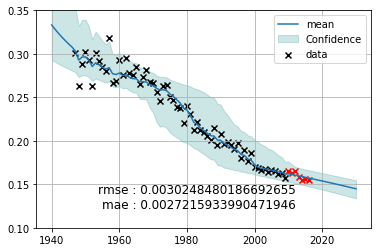

 52%|█████▏    | 672/1296 [1:30:22<3:08:55, 18.17s/it]

0.0030248480186692655 0.0027215933990471946
(('sal', 2), ('sa', 1), ('box_cox', 1), ('sa', 1))


 52%|█████▏    | 673/1296 [1:30:31<2:41:57, 15.60s/it]

params:[-9.70241197e-02  1.91128844e+02]
0.007514318354892139 0.006908559027272145
(('sal', 2), ('sa', 1), ('box_cox', 1), ('sa', 2))
params:[-8.46923377e-02  1.67266090e+02]


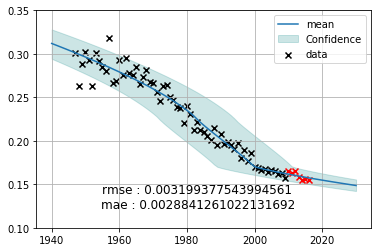

 52%|█████▏    | 674/1296 [1:30:45<2:35:42, 15.02s/it]

0.003199377543994561 0.0028841261022131692
(('sal', 2), ('sa', 1), ('box_cox', 1), ('sal', 1))


 52%|█████▏    | 675/1296 [1:31:07<2:57:42, 17.17s/it]

params:[-9.73273840e-02  1.92810648e+02]
0.0036411769966307275 0.0028642172235042807
(('sal', 2), ('sa', 1), ('box_cox', 1), ('sal', 2))


 52%|█████▏    | 676/1296 [1:31:39<3:42:22, 21.52s/it]

params:[-1.01220024e-01  2.00514913e+02]
0.004000118232575836 0.0029985839479204474
(('sal', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 1))


 52%|█████▏    | 677/1296 [1:31:49<3:06:53, 18.12s/it]

params:[-9.47352232e-02  1.85661433e+02]
0.0042285927614474595 0.0032503013550995085
(('sal', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


 52%|█████▏    | 678/1296 [1:31:59<2:39:56, 15.53s/it]

params:[-6.91829277e-02  1.34064621e+02]
0.005436903100563646 0.004264030599266598
(('sal', 2), ('sa', 1), ('box_cox', 2), ('sa', 1))


 52%|█████▏    | 679/1296 [1:32:19<2:55:55, 17.11s/it]

params:[-7.99164262e-02  1.57120760e+02]
0.003876894395027766 0.002948152484351394
(('sal', 2), ('sa', 1), ('box_cox', 2), ('sa', 2))


 52%|█████▏    | 680/1296 [1:32:33<2:44:31, 16.02s/it]

params:[-8.38972642e-02  1.65051336e+02]
0.004786333485330625 0.003544823062449667
(('sal', 2), ('sa', 1), ('box_cox', 2), ('sal', 1))


 53%|█████▎    | 681/1296 [1:32:41<2:18:39, 13.53s/it]

params:[-1.01922194e-01  2.01906551e+02]
0.0046100170108551225 0.0034090042920814196
(('sal', 2), ('sa', 1), ('box_cox', 2), ('sal', 2))


 53%|█████▎    | 682/1296 [1:33:19<3:36:06, 21.12s/it]

params:[-9.50118808e-02  1.88311590e+02]
0.0037165734087479647 0.003008566399557544
(('sal', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


 53%|█████▎    | 683/1296 [1:33:32<3:08:39, 18.47s/it]

params:[-8.78538850e-02  1.72187758e+02]
0.0037197491962377956 0.00332636801364342
(('sal', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


 53%|█████▎    | 684/1296 [1:33:34<2:18:16, 13.56s/it]

params:[-6.47366029e-02  1.23319122e+02]
0.004682912395186502 0.004146461404407129
(('sal', 2), ('sa', 2), ('sa', 1), ('sa', 1))


In [ ]:
result = grid_search(cwgp_regression, year, rate, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]})


In [ ]:
sa1sa1sa1bc2(-8.39185469e-02  1.63633232e+02)